# Introduction
In this notebook, we will try to predict whether an individual makes more or less than certain amount of money. This is a binary classification task that depends on the various parameters. All the information in `readme` section 

## Table of contents
*  [Import Required Libraries](#import)
*  [Load Data](#load)
*  [Exploratory Data Analysis](#eda)
*  [Feature Enginneering](#feature_engineering)
*  [Implementing ML models](#implementing_models)
*  [Making Predictions](#making_predictions)

## Import Required Libraries <a name="import"></a>

In [123]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import normalize
import xgboost as xgb

# Allow seeing warnings only once
import warnings
warnings.filterwarnings(action='once')

# ML Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
import xgboost as xgb



# FigSize
plt.rcParams['figure.figsize'] = (12, 8)


## Load Data  <a name="load"></a>

In [2]:
columns = ['age', 'work_class', 'final_weight', 'education', 'education_num',
           'marital_status', 'occupation', 'relationship', 'race', 'sex',
           'cap_gain', 'cap_loss', 'hours_per_week', 'native_country']

numerical_columns = ['age', 'final_weight', 'education_num', 'cap_gain',
                  'cap_loss', 'hours_per_week']

categorical_columns = ['work_class', 'education', 'marital_status', 'occupation',
                    'relationship', 'race', 'sex', 'native_country']

# train_data_path = 'test_task_ml/data.txt' # Used in my local pc

train_data_path = 'data.txt'
train_df = pd.read_csv(train_data_path, sep=', ', header=None, names = columns + ['target'], engine='python')


# test_data_path = 'test_task_ml/test_empty.txt' # Used in my local pc
test_data_path = 'test_task_ml/test_empty.txt'
test_df = pd.read_csv(test_data_path, sep=', ', header=None, skiprows=[0], names=columns, engine='python')

In [3]:
# train=32575, test=16286
print('length of train dataframe:', len(train_df)) # Expected train df: 32575
print('length of test dataframe:', len(test_df)) # Expected test df: 16286

length of train dataframe: 32573
length of test dataframe: 16283


## Exploratory Data Analysis  <a name="eda"></a>

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32573 entries, 0 to 32572
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             32573 non-null  object 
 1   work_class      32572 non-null  object 
 2   final_weight    32572 non-null  float64
 3   education       32572 non-null  object 
 4   education_num   32572 non-null  object 
 5   marital_status  32572 non-null  object 
 6   occupation      32572 non-null  object 
 7   relationship    32572 non-null  object 
 8   race            32572 non-null  object 
 9   sex             32572 non-null  object 
 10  cap_gain        32572 non-null  float64
 11  cap_loss        32572 non-null  float64
 12  hours_per_week  32572 non-null  object 
 13  native_country  32572 non-null  object 
 14  target          32571 non-null  object 
dtypes: float64(3), object(12)
memory usage: 3.7+ MB


We can see that there are some `nan` values in the `train_df`. Lets check it with `isna()` function

In [5]:
train_df[train_df.isna().any(axis=1)]

,age,work_class,final_weight,education,education_num,marital_status,occupation,relationship,race,sex,cap_gain,cap_loss,hours_per_week,native_country,target
16324,totally_legit_string,None,NaN,None,None,None,None,None,None,None,NaN,NaN,None,None,None
26556,-321,Private,2.312322e+17,Some-college,Machine-op-inspct,Sales,Husband,White,Other,0,-1.0,-444.0,United-States,>N,None


Those rows contain multiple `nan` values and have unreasonable entries. For example, row `26556` has age as -321 and some features mixed (Sales should be under occupation column, not marital_status. Therefore, they should be replace with each other)

In [6]:
train_df = train_df.drop(train_df[train_df.isna().any(axis=1)].index)

print('train dataframe length after dropping those rows:', len(train_df)) # Used to be 32573

train_df.info()

train dataframe length after dropping those rows: 32571
<class 'pandas.core.frame.DataFrame'>
Int64Index: 32571 entries, 0 to 32572
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             32571 non-null  object 
 1   work_class      32571 non-null  object 
 2   final_weight    32571 non-null  float64
 3   education       32571 non-null  object 
 4   education_num   32571 non-null  object 
 5   marital_status  32571 non-null  object 
 6   occupation      32571 non-null  object 
 7   relationship    32571 non-null  object 
 8   race            32571 non-null  object 
 9   sex             32571 non-null  object 
 10  cap_gain        32571 non-null  float64
 11  cap_loss        32571 non-null  float64
 12  hours_per_week  32571 non-null  object 
 13  native_country  32571 non-null  object 
 14  target          32571 non-null  object 
dtypes: float64(3), object(12)
memory usage: 4.0+ MB


Now we can explore the dataframe column by column

### Age

In [7]:
print(train_df['age'].dtypes) # Object
# Convert to int 
train_df['age'] = train_df['age'].astype(np.uint8)
train_df['age'].describe()

object


count    32571.000000
mean        38.570108
std         13.654222
min          1.000000
25%         28.000000
50%         37.000000
75%         48.000000
max         90.000000
Name: age, dtype: float64

Minimum age is 1 which is very odd. Let's sort the unique values of the column in ascending order.

In [8]:
print('Sorted Age column Array:\n', sorted(train_df['age'].unique()))

train_df[train_df['age'] == 1]

Sorted Age column Array:
 [1, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 90]


,age,work_class,final_weight,education,education_num,marital_status,occupation,relationship,race,sex,cap_gain,cap_loss,hours_per_week,native_country,target
26557,1,State-gov,-42141.0,Some-college,10,Never-married,Machine-op-inspct,Sales,Black,Other,100.0,-110.0,444424124141242,United-States,>N
26558,1,State-gov,-42141.0,Some-college,10,Never-married,Machine-op-inspct,Sales,Black,Other,100.0,-110.0,444424124141242,United-States,>N
26559,1,State-gov,-42141.0,Some-college,10,Never-married,Machine-op-inspct,Sales,Black,Other,100.0,-110.0,444424124141242,United-States,>N
26560,1,State-gov,-42141.0,Some-college,10,Never-married,Machine-op-inspct,Sales,Black,Other,100.0,-110.0,444424124141242,United-States,>N
26561,1,State-gov,-42141.0,Some-college,10,Never-married,Machine-op-inspct,Sales,Black,Other,100.0,-110.0,444424124141242,United-States,>N
26562,1,State-gov,-42141.0,Some-college,10,Never-married,Machine-op-inspct,Sales,Black,Other,100.0,-110.0,444424124141242,United-States,>N
26563,1,State-gov,-42141.0,Some-college,10,Never-married,Machine-op-inspct,Sales,Black,Other,100.0,-110.0,444424124141242,United-States,>N
26564,1,State-gov,-42141.0,Some-college,10,Never-married,Machine-op-inspct,Sales,Black,Other,100.0,-110.0,444424124141242,United-States,>N
26565,1,State-gov,-42141.0,Some-college,10,Never-married,Machine-op-inspct,Sales,Black,Other,100.0,-110.0,444424124141242,United-States,>N
26566,1,State-gov,-42141.0,Some-college,10,Never-married,Machine-op-inspct,Sales,Black,Other,100.0,-110.0,444424124141242,United-States,>N


Another faulty data as `hours_per_week` value is absurdly high taking into account that entries for other columns are reasonable. Thus, need to remote them 

In [9]:
# Inspect and Remove dataframe rows with age = 1
print('Number of dropped rows:', len(train_df[train_df['age']==1]))
# No need to remove rows where age == 17

train_df = train_df[train_df['age'].values != 1]
print(f'train_df size: {len(train_df)}.')

Number of dropped rows: 10
train_df size: 32561.


In [10]:
print('Unique age entries at train dataframe:', set(train_df['age'].unique()))
print('-'*127)
print('Unique age entries at test dataframe:', set(test_df['age'].unique()))

Unique age entries at train dataframe: {17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 90}
-------------------------------------------------------------------------------------------------------------------------------
Unique age entries at test dataframe: {'84', '69', '49', '-10', '60', '73', '57', '20', '36', '44', '63', '40', '52', '85', '29', '74', '77', '83', 'fssafsa121321ewd1231e2', '26', '70', '37', '48', '71', '18', '23', '65', '41', '25', '53', '54', '46', '88', '21', '30', '87', '32', '81', '42', '24', '33', '56', '61', '39', '19', '55', '59', '79', '75', '89', '47', '43', '31', '64', '35', '28', '38', '51', '80', '90', '76', '72', '67', '45', '50', '62', '68', '82', '58', '17', '66', '22', '27', '34', '78'}


Train_df looks alright, Test_df has some odd entries such as `fssafsa121321ewd1231e2` and `-10`. 

In [11]:
test_df[(test_df['age']=='fssafsa121321ewd1231e2') | (test_df['age']=='-10')] 
# We can delete them from test_df as they are probably trash

,age,work_class,final_weight,education,education_num,marital_status,occupation,relationship,race,sex,cap_gain,cap_loss,hours_per_week,native_country
12513,fssafsa121321ewd1231e2,None,NaN,None,NaN,None,None,None,None,None,NaN,NaN,NaN,None
14154,-10,PRIVATE,-21321.414,HS-grad,1.023021e+11,Divorced,Sales,Husband,White,Male,12.0,32.0,-321321421.0,United-States


In [12]:
print('Len of test_df before droping 2 rows:', len(test_df))
test_df = test_df.drop(test_df[(test_df['age']=='fssafsa121321ewd1231e2') | (test_df['age']=='-10')].index) 
print('Len of the test_df after dropping 2 rows:', len(test_df))

Len of test_df before droping 2 rows: 16283
Len of the test_df after dropping 2 rows: 16281


In [13]:
def test_train_difference(test_df, train_df, column):
    return(set(test_df[column].unique()) - set(train_df[column].unique()))


### work_class	

In [14]:
print(train_df['work_class'].value_counts(dropna=False))

Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: work_class, dtype: int64


In [15]:
# Lets check what is inside of '?' work_class
train_df[train_df['work_class'] == '?']

,age,work_class,final_weight,education,education_num,marital_status,occupation,relationship,race,sex,cap_gain,cap_loss,hours_per_week,native_country,target
27,54,?,180211.0,Some-college,10,Married-civ-spouse,?,Husband,Asian-Pac-Islander,Male,0.0,0.0,60,South,>N
61,32,?,293936.0,7th-8th,4,Married-spouse-absent,?,Not-in-family,White,Male,0.0,0.0,40,?,<=N
69,25,?,200681.0,Some-college,10,Never-married,?,Own-child,White,Male,0.0,0.0,40,United-States,<=N
77,67,?,212759.0,10th,6,Married-civ-spouse,?,Husband,White,Male,0.0,0.0,2,United-States,<=N
106,17,?,304873.0,10th,6,Never-married,?,Own-child,White,Female,34095.0,0.0,32,United-States,<=N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32542,35,?,320084.0,Bachelors,13,Married-civ-spouse,?,Wife,White,Female,0.0,0.0,55,United-States,>N
32543,30,?,33811.0,Bachelors,13,Never-married,?,Not-in-family,Asian-Pac-Islander,Female,0.0,0.0,99,United-States,<=N
32551,71,?,287372.0,Doctorate,16,Married-civ-spouse,?,Husband,White,Male,0.0,0.0,10,United-States,>N
32553,41,?,202822.0,HS-grad,9,Separated,?,Not-in-family,Black,Female,0.0,0.0,32,United-States,<=N


Let's check the difference between test_df and train_df entries for work_class column

In [16]:
test_train_difference(test_df, train_df, 'work_class')

set()

We can see that that test_df has `PRIVATE` entry while the train_df has `Private` one. Therefore, we need to replace it. 

In [17]:
test_df.loc[test_df['work_class'] == 'PRIVATE', 'work_class'] = 'Private'
test_train_difference(test_df, train_df, 'work_class')

set()

### Final Weight

In [18]:
train_df['final_weight'].describe()

count    3.256100e+04
mean     1.897784e+05
std      1.055500e+05
min      1.228500e+04
25%      1.178270e+05
50%      1.783560e+05
75%      2.370510e+05
max      1.484705e+06
Name: final_weight, dtype: float64

No nan values in `train_df` and `test_df`

In [19]:
train_df[train_df['final_weight'].isna()]

,age,work_class,final_weight,education,education_num,marital_status,occupation,relationship,race,sex,cap_gain,cap_loss,hours_per_week,native_country,target


In [20]:
test_df[test_df['final_weight'].isna()]

,age,work_class,final_weight,education,education_num,marital_status,occupation,relationship,race,sex,cap_gain,cap_loss,hours_per_week,native_country


In [21]:
print("Number of unique elements in the train dataframe:", train_df['final_weight'].nunique())

train_df['final_weight'].value_counts() # Can See that there are many unique elements


Number of unique elements in the train dataframe: 21648


164190.0    13
123011.0    13
203488.0    13
121124.0    12
113364.0    12
            ..
109418.0     1
176073.0     1
198801.0     1
130397.0     1
95113.0      1
Name: final_weight, Length: 21648, dtype: int64

In [22]:
print("Number of unique elements in the test dataframe:", test_df['final_weight'].nunique())

test_df['final_weight'].value_counts()

Number of unique elements in the test dataframe: 12787


136986.0    9
190290.0    8
117310.0    8
127651.0    8
120277.0    8
           ..
242832.0    1
272671.0    1
126677.0    1
152719.0    1
102400.0    1
Name: final_weight, Length: 12787, dtype: int64

### education

In [23]:
test_train_difference(test_df, train_df, 'education')

set()

In [24]:
print('Education column value counts:\n',train_df['education'].value_counts())

Education column value counts:
 HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: education, dtype: int64


### education_num

In [25]:
# This column is written as object
print('Type of the education_num column:', train_df['education_num'].dtypes)

# Convert to int
train_df['education_num'] = train_df['education_num'].astype(np.uint8)

Type of the education_num column: object


In [26]:
train_df['education_num'].describe()

count    32561.000000
mean        10.080679
std          2.572720
min          1.000000
25%          9.000000
50%         10.000000
75%         12.000000
max         16.000000
Name: education_num, dtype: float64

In [27]:
train_df[train_df['education_num'].isna()]

,age,work_class,final_weight,education,education_num,marital_status,occupation,relationship,race,sex,cap_gain,cap_loss,hours_per_week,native_country,target


In [28]:
print('education_num column value counts:')

print(train_df['education_num'].value_counts())

education_num column value counts:
9     10501
10     7291
13     5355
14     1723
11     1382
7      1175
12     1067
6       933
4       646
15      576
5       514
8       433
16      413
3       333
2       168
1        51
Name: education_num, dtype: int64


In [29]:
test_train_difference(test_df, train_df, 'education_num')

set()

### Marital Status

In [30]:
test_train_difference(test_df, train_df, 'marital_status')

set()

In [31]:
print('marital status column:\n')
print(train_df['marital_status'].value_counts())

marital status column:

Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: marital_status, dtype: int64


### Occupation

In [32]:
test_train_difference(test_df, train_df, 'occupation')

set()

In [33]:
print('Statistics of categorical column:\n', train_df['occupation'].describe())
print('\n')
print('Most frequent values in occupation column:\n', train_df['occupation'].value_counts())

Statistics of categorical column:
 count              32561
unique                15
top       Prof-specialty
freq                4140
Name: occupation, dtype: object


Most frequent values in occupation column:
 Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
?                    1843
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: occupation, dtype: int64


In [34]:
train_df.columns

Index(['age', 'work_class', 'final_weight', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'cap_gain', 'cap_loss', 'hours_per_week', 'native_country', 'target'],
      dtype='object')

### relationship

In [35]:
test_train_difference(test_df, train_df, 'relationship')

set()

In [36]:
print('Statistics of categorical column:\n', train_df['relationship'].describe())
print('\n')
print('Most frequent values in occupation column:\n', train_df['relationship'].value_counts())

Statistics of categorical column:
 count       32561
unique          6
top       Husband
freq        13193
Name: relationship, dtype: object


Most frequent values in occupation column:
 Husband           13193
Not-in-family      8305
Own-child          5068
Unmarried          3446
Wife               1568
Other-relative      981
Name: relationship, dtype: int64


### race

In [37]:
test_train_difference(test_df, train_df, 'race')

set()

In [38]:
print('Statistics of categorical column:\n', train_df['race'].describe())
print('\n')
print('Most frequent values in occupation column:\n', train_df['race'].value_counts())

Statistics of categorical column:
 count     32561
unique        5
top       White
freq      27816
Name: race, dtype: object


Most frequent values in occupation column:
 White                 27816
Black                  3124
Asian-Pac-Islander     1039
Amer-Indian-Eskimo      311
Other                   271
Name: race, dtype: int64


### sex

In [39]:
test_train_difference(test_df, train_df, 'sex')

set()

In [40]:
print('Statistics of categorical column:\n', train_df['sex'].describe())
print('\n')
print('Most frequent values in occupation column:\n', train_df['sex'].value_counts())

Statistics of categorical column:
 count     32561
unique        2
top        Male
freq      21790
Name: sex, dtype: object


Most frequent values in occupation column:
 Male      21790
Female    10771
Name: sex, dtype: int64


### cap_gain

In [41]:
test_train_difference(test_df, train_df, 'cap_gain') # Its okay, no unreasonable values

{1264.0, 1731.0, 6612.0, 7262.0}

In [42]:
train_df['cap_gain'].describe()

count    32561.000000
mean      1077.648844
std       7385.292085
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      99999.000000
Name: cap_gain, dtype: float64

It is odd that values for min, 25%, 50% and 75% are all 0.0 

Lets create the histogram plot and see the plot

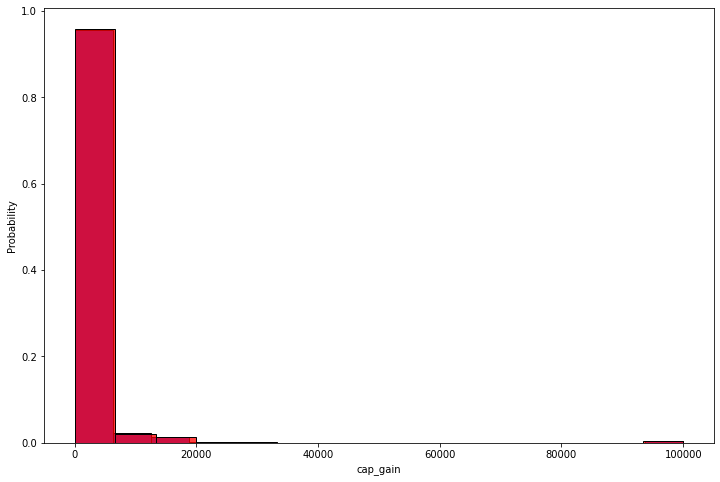

In [43]:
sns.histplot(train_df['cap_gain'], stat='probability', color='b');
sns.histplot(test_df['cap_gain'], stat='probability', color='r');

### cap_loss

In [44]:
test_train_difference(test_df, train_df, 'cap_loss') # Its okay, no unreasonable values

{1421.0, 1429.0, 1510.0, 1870.0, 1911.0, 2465.0, 3175.0}

In [45]:
train_df['cap_loss'].describe()

count    32561.000000
mean        87.303830
std        402.960219
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       4356.000000
Name: cap_loss, dtype: float64

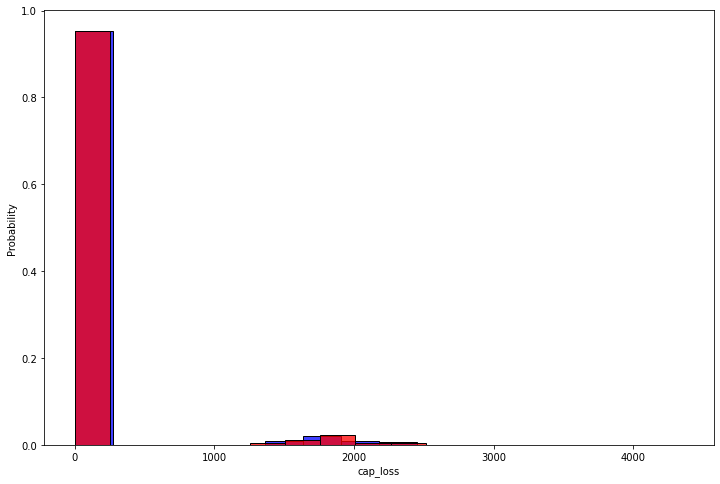

In [46]:
sns.histplot(train_df['cap_loss'], stat='probability', color='b');
sns.histplot(test_df['cap_loss'], stat='probability', color='r');

### hours_per_week

In [47]:
# This column is written as object
print('Type of the hours_per_week column:', train_df['hours_per_week'].dtypes)

# Convert to int
train_df['hours_per_week'] = train_df['hours_per_week'].astype(np.uint8)

train_df['hours_per_week'].describe()

Type of the hours_per_week column: object


count    32561.000000
mean        40.437456
std         12.347429
min          1.000000
25%         40.000000
50%         40.000000
75%         45.000000
max         99.000000
Name: hours_per_week, dtype: float64

### native_country

In [48]:
print('Difference of entries in two dataframes:',test_train_difference(test_df, train_df, 'native_country'))

print('Value counts of native country column:\n',train_df['native_country'].value_counts())

# May be delete countries with '?' sign. Cause it might be hard to distinguish target salary based on that. Also

Difference of entries in two dataframes: set()
Value counts of native country column:
 United-States                 29170
Mexico                          643
?                               583
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England                          90
Jamaica                          81
South                            80
China                            75
Italy                            73
Dominican-Republic               70
Vietnam                          67
Guatemala                        64
Japan                            62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal                         37
Nicaragua    

Observation: The salaries of people living in the first world countries may be frequently above the certain threshold while the ones living in poorer contries may not be

### target
Final column and target value will be `target` column

In [49]:
print(train_df['target'].value_counts())

print('Percentage of <=N data in the dataframe:', len(train_df[train_df['target'] == '<=N'])/len(train_df) * 100)
print('Percentage of >N data in the dataframe:', len(train_df[train_df['target'] == '>N'])/len(train_df) * 100)

<=N    24720
>N      7841
Name: target, dtype: int64
Percentage of <=N data in the dataframe: 75.91904425539757
Percentage of >N data in the dataframe: 24.080955744602438


/home/bbatayev/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Target Distributions\n (<=N || >N)')

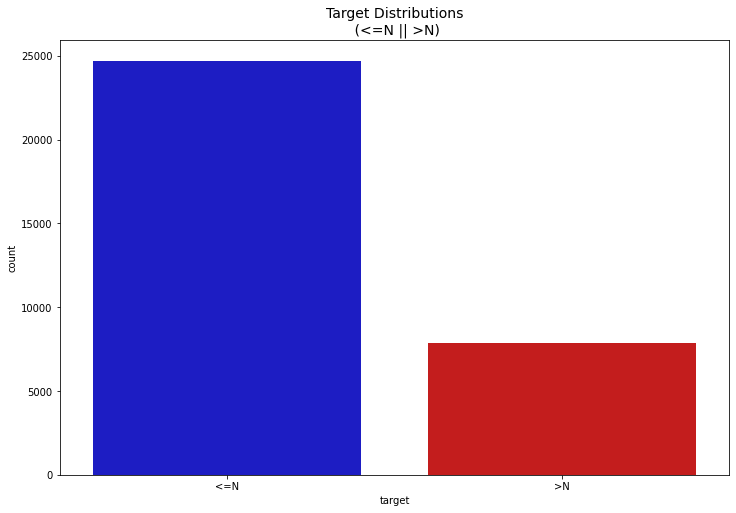

In [50]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('target', data=train_df, palette=colors)
plt.title('Target Distributions\n (<=N || >N)', fontsize=14)

We can observe a data imbalance. Probably it will be a good idea to use undersampling/oversampling techniques. Firstly, we need to convert them to binary representations

In [51]:
target = {'<=N': 0, '>N': 1}

inv_target = {v: k for k, v in target.items()}

train_df['target'] = train_df['target'].map(target).astype(np.uint8)

In [52]:
train_df['target']

0        0
1        0
2        0
3        0
4        0
        ..
32568    0
32569    1
32570    0
32571    0
32572    1
Name: target, Length: 32561, dtype: uint8

In [53]:
# Check Whether people from United States and other first world countries have higher target rate
train_df['native_country'].unique()
first_world_countries = ['United-States', 'England', 'Canada', 'Germany', 'Italy', 'Scotland', 'Portugal', 'France', 'Japan', 'Ireland',
                        'Hungary', 'Holand-Netherlands']
mean_rich_countries = 0
for country in first_world_countries:
    mean_rich_countries += (len(train_df[(train_df['native_country'] == country) & (train_df['target'] == 1)]) /
          len(train_df[(train_df['native_country'] == country) & (train_df['target'] == 0)]))
    
mean_rich_countries/len(first_world_countries)

0.387557948403035

In [54]:
not_so_rich_countries = 0
for country in train_df['native_country'].unique():
    if country not in first_world_countries:
        not_so_rich_countries += (len(train_df[(train_df['native_country'] == country) & (train_df['target'] == 1)]) /
              len(train_df[(train_df['native_country'] == country) & (train_df['target'] == 0)]))
        
not_so_rich_countries/(len(train_df['native_country'].unique()) - len(first_world_countries))    

0.25162091497342115

Important to note that richer countries have higher percent of people having required amount

### Statistics

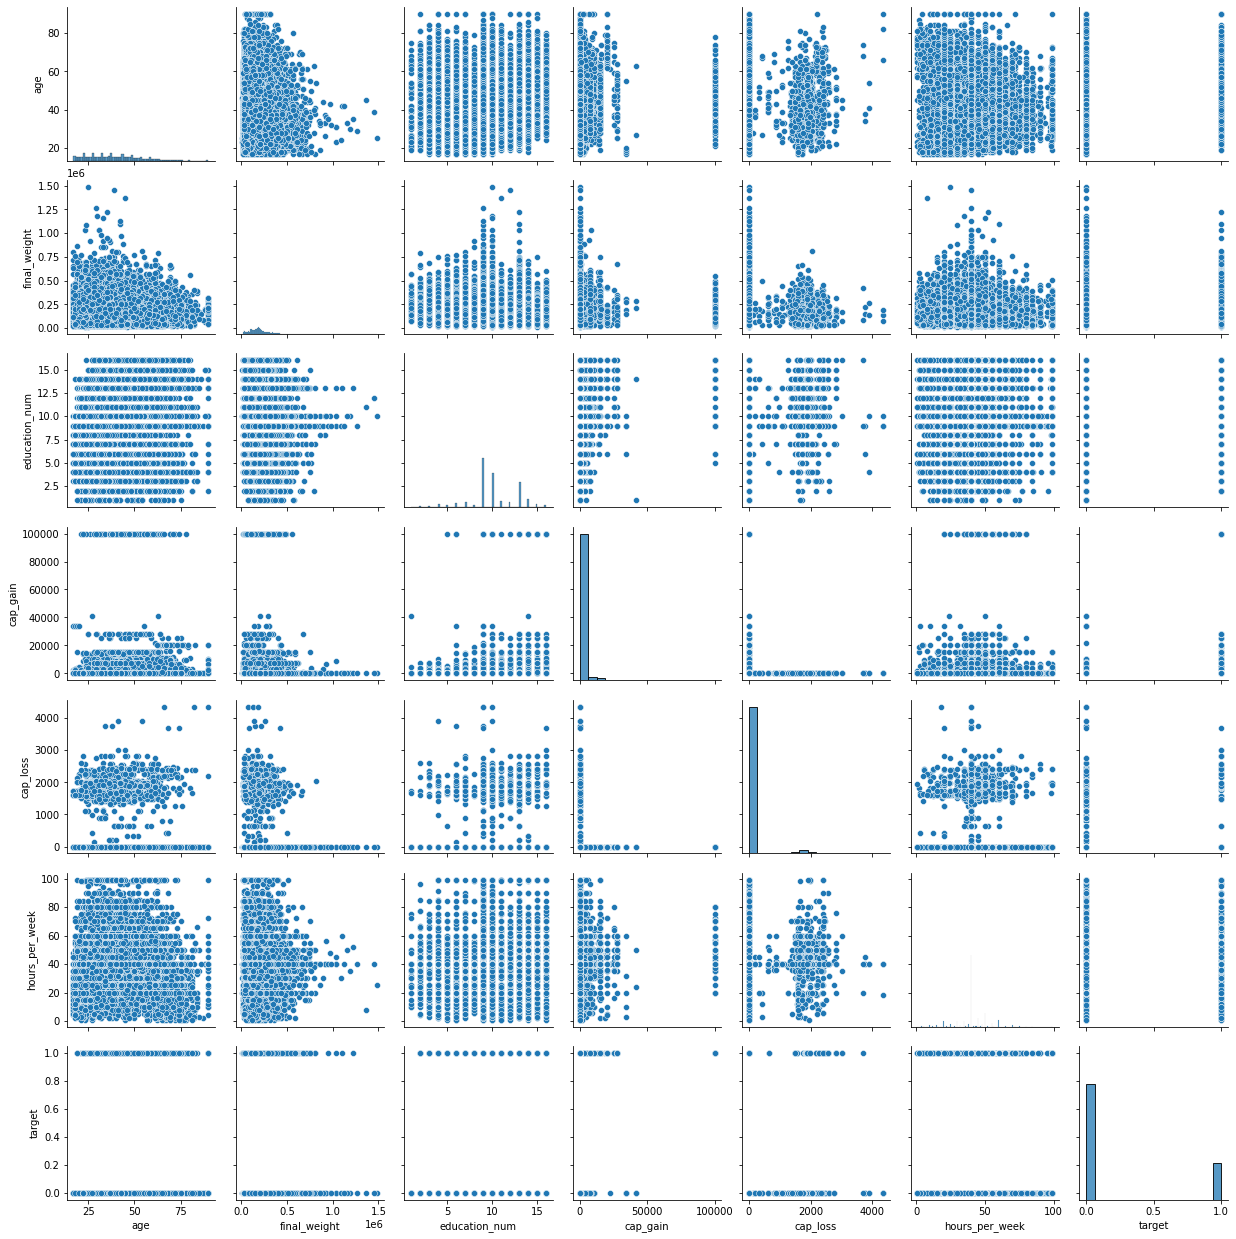

In [55]:
sns.pairplot(train_df)

In [56]:
# Columns that can be potentially ranked: education is probably already ranked in education_num
train_df['education_num']

0        13
1        13
2         9
3         7
4        13
         ..
32568    12
32569     9
32570     9
32571     9
32572     9
Name: education_num, Length: 32561, dtype: uint8

In [57]:
train_df.dtypes

age                 uint8
work_class         object
final_weight      float64
education          object
education_num       uint8
marital_status     object
occupation         object
relationship       object
race               object
sex                object
cap_gain          float64
cap_loss          float64
hours_per_week      uint8
native_country     object
target              uint8
dtype: object

In [58]:
train_df.columns 

Index(['age', 'work_class', 'final_weight', 'education', 'education_num',
       'marital_status', 'occupation', 'relationship', 'race', 'sex',
       'cap_gain', 'cap_loss', 'hours_per_week', 'native_country', 'target'],
      dtype='object')

In [59]:
train_df['native_country'].unique()

array(['United-States', 'Cuba', 'Jamaica', 'India', '?', 'Mexico',
       'South', 'Puerto-Rico', 'Honduras', 'England', 'Canada', 'Germany',
       'Iran', 'Philippines', 'Italy', 'Poland', 'Columbia', 'Cambodia',
       'Thailand', 'Ecuador', 'Laos', 'Taiwan', 'Haiti', 'Portugal',
       'Dominican-Republic', 'El-Salvador', 'France', 'Guatemala',
       'China', 'Japan', 'Yugoslavia', 'Peru',
       'Outlying-US(Guam-USVI-etc)', 'Scotland', 'Trinadad&Tobago',
       'Greece', 'Nicaragua', 'Vietnam', 'Hong', 'Ireland', 'Hungary',
       'Holand-Netherlands'], dtype=object)

## Feature Engineering  <a name="feature_engineering"></a>

### Encoding
#### Lets firstly try to do the Label Encoding

In [60]:
# Import encoding functions
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [61]:
train_df_copy_le = train_df.copy()
label_encoder = LabelEncoder()
for col in categorical_columns:
    train_df_copy_le[col] = label_encoder.fit_transform(train_df_copy_le[col])
    
train_df_copy_le.sample(10)

,age,work_class,final_weight,education,education_num,marital_status,occupation,relationship,race,sex,cap_gain,cap_loss,hours_per_week,native_country,target
29369,50,4,176227.0,9,13,2,4,0,4,1,0.0,0.0,40,0,1
13493,64,0,193043.0,11,9,2,0,0,4,1,0.0,0.0,40,39,0
25469,27,4,209891.0,15,10,4,6,1,2,1,0.0,0.0,50,39,0
11989,43,4,118536.0,11,9,0,7,2,2,1,0.0,0.0,40,39,0
13561,34,4,206297.0,9,13,2,4,0,4,1,0.0,0.0,48,39,1
26929,28,4,175987.0,11,9,4,4,1,4,0,0.0,0.0,40,39,0
4425,29,4,209301.0,9,13,2,3,0,4,1,0.0,0.0,40,2,0
27331,43,6,180985.0,9,13,5,3,4,4,1,0.0,0.0,35,39,0
7713,28,4,50814.0,11,9,4,1,1,4,0,0.0,0.0,40,39,0
13656,30,2,101345.0,11,9,5,8,4,4,0,0.0,0.0,26,39,0


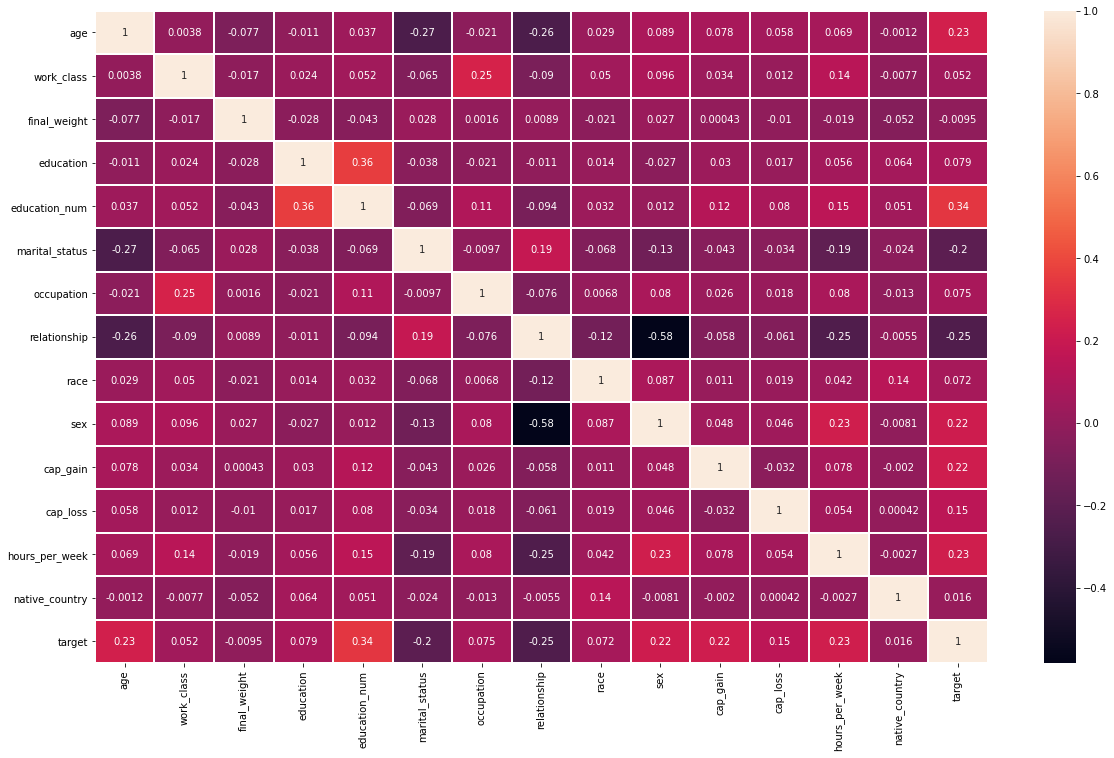

In [62]:
plt.figure(figsize=(20, 12))
sns.heatmap(train_df_copy_le.corr(), annot=True, linewidths=0.1);

In [63]:
print("len of dataframe before deleting duplicates:", len(train_df))
train_df = train_df.drop_duplicates()
print("len of dataframe before deleting duplicates:", len(train_df))


len of dataframe before deleting duplicates: 32561
len of dataframe before deleting duplicates: 32537


In [64]:
train_df.corr()

,age,final_weight,education_num,cap_gain,cap_loss,hours_per_week,target
age,1.000000,-0.076447,0.036224,0.077676,0.057745,0.068515,0.234037
final_weight,-0.076447,1.000000,-0.043388,0.000429,-0.010260,-0.018898,-0.009502
education_num,0.036224,-0.043388,1.000000,0.122664,0.079892,0.148422,0.335272
cap_gain,0.077676,0.000429,0.122664,1.000000,-0.031639,0.078408,0.223336
cap_loss,0.057745,-0.010260,0.079892,-0.031639,1.000000,0.054229,0.150501
hours_per_week,0.068515,-0.018898,0.148422,0.078408,0.054229,1.000000,0.229658
target,0.234037,-0.009502,0.335272,0.223336,0.150501,0.229658,1.000000


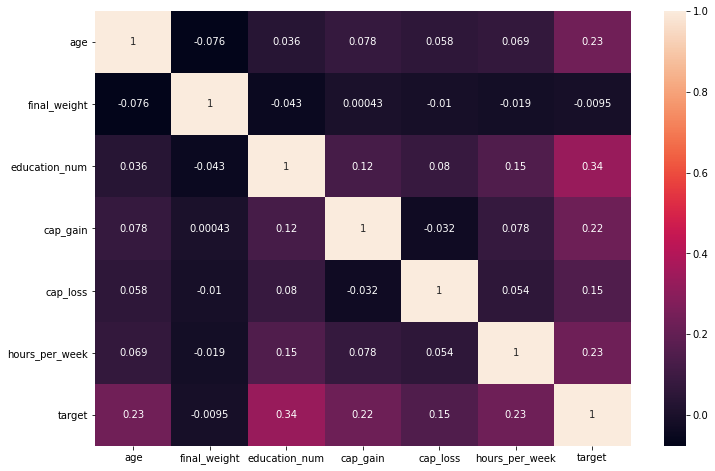

In [65]:
sns.heatmap(data=train_df.corr(), annot=True);

We can see that `cap_gain` and `cap_loss` have small correlations with each other and `final_weight` column has small correlation with everything else. May be combining `cap_gain` and `cap_loss` into one feature can help

<ipython-input-66-f22d3b9cbc30>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['cap_diff'] = train_df['cap_gain'] - train_df['cap_loss']


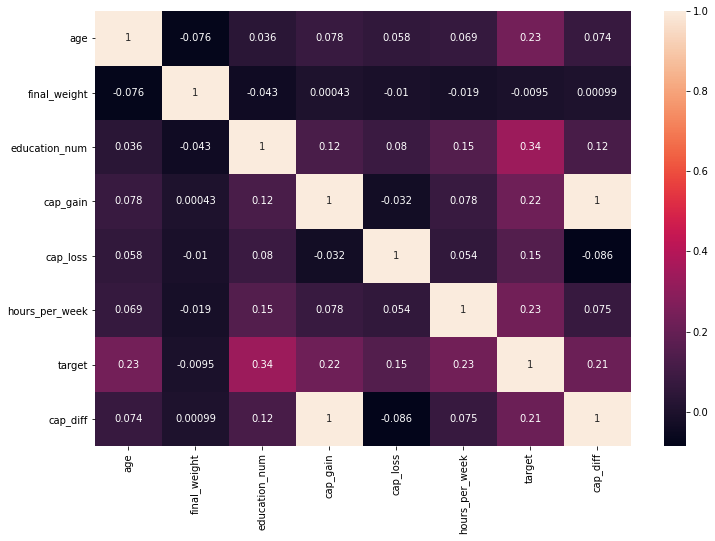

In [66]:
train_df['cap_diff'] = train_df['cap_gain'] - train_df['cap_loss']
sns.heatmap(data=train_df.corr(), annot=True);

In [67]:
from sklearn.preprocessing import normalize

In [70]:
def encode_categorical_features(df, train_data, column_name):
    '''Encode only categorical features'''
    le = LabelEncoder()
    le.fit(train_data[column_name])
    df[column_name] = le.transform(df[column_name])

def normalize_data(df):
    '''Normalize data'''
    scaled_df = pd.DataFrame(normalize(df,axis=0), columns=df.columns)
    return scaled_df

In [71]:
prepared_train_data = train_df.copy()
for col in categorical_columns:
    encode_categorical_features(prepared_train_data, train_df, col)

In [72]:
prepared_train_data

,age,work_class,final_weight,education,education_num,marital_status,occupation,relationship,race,sex,cap_gain,cap_loss,hours_per_week,native_country,target,cap_diff
0,39,7,77516.0,9,13,4,1,1,4,1,2174.0,0.0,40,39,0,2174.0
1,50,6,83311.0,9,13,2,4,0,4,1,0.0,0.0,13,39,0,0.0
2,38,4,215646.0,11,9,0,6,1,4,1,0.0,0.0,40,39,0,0.0
3,53,4,234721.0,1,7,2,6,0,2,1,0.0,0.0,40,39,0,0.0
4,28,4,338409.0,9,13,2,10,5,2,0,0.0,0.0,40,5,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32568,27,4,257302.0,7,12,2,13,5,4,0,0.0,0.0,38,39,0,0.0
32569,40,4,154374.0,11,9,2,7,0,4,1,0.0,0.0,40,39,1,0.0
32570,58,4,151910.0,11,9,6,1,4,4,0,0.0,0.0,40,39,0,0.0
32571,22,4,201490.0,11,9,4,1,3,4,1,0.0,0.0,20,39,0,0.0


Lets delete some columns. We do not need `final_weight`, `cap_gain` and `cap_loss`

In [73]:
prepared_train_data = prepared_train_data.drop(columns=['final_weight', 'cap_gain', 'cap_loss'], axis=1)

In [74]:
prepared_train_data = prepared_train_data.drop_duplicates()
prepared_train_data.shape

(29096, 13)

Now we check the correlation of all features on target value:


In [75]:
def get_comparison_correlations(df):
    print(df.corr()['target'].sort_values(ascending=False))
get_comparison_correlations(prepared_train_data)

target            1.000000
education_num     0.332210
hours_per_week    0.226323
cap_diff          0.221586
sex               0.216816
age               0.215270
education         0.091760
race              0.079826
occupation        0.073405
work_class        0.047887
native_country    0.021352
marital_status   -0.189776
relationship     -0.245918
Name: target, dtype: float64


# Implementing ML models <a name="implementing_models"></a>

In [162]:
# Metric will be ROC-AUC curve
def plot_roc_auc_curve(y_test, y_pred, label = None):
    '''Plots ROC-AUC Curve'''
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.figure(figsize=[20,20])
    plt.show();
    auc_score = roc_auc_score(y_test, y_pred)
    print('AUC SCORE:', auc_score)

/home/bbatayev/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [218]:
y = prepared_train_data.target
X = prepared_train_data.drop(axis=1, columns=['target'])

/home/bbatayev/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [219]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [146]:
prepared_train_data['target'].value_counts()

/home/bbatayev/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0    21886
1     7210
Name: target, dtype: int64

## BaseLine
Before using any ML models, Let's try to always predict positive class

F1-score: 0.39658339456282143


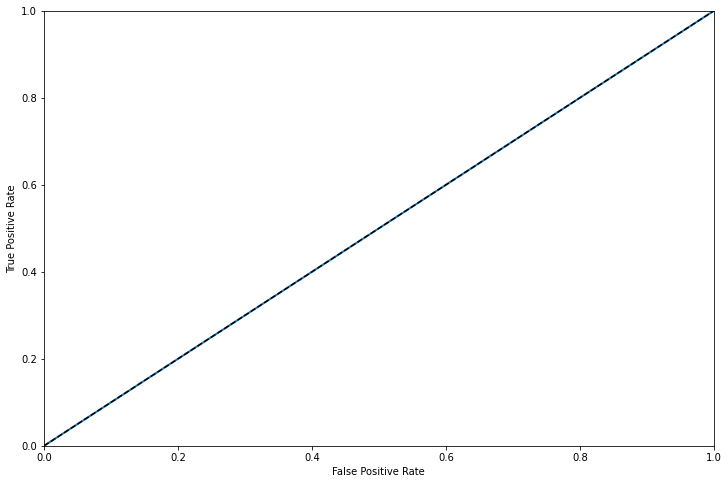

<Figure size 1440x1440 with 0 Axes>

AUC SCORE: 0.5


In [152]:
y_pred = np.ones_like(y_test)
print(f'F1-score: {f1_score(y_test, y_pred)}')
plot_roc_auc_curve(y_test, y_pred)

Now let's just randomly predict the positive target class with probability equal to the posiive class ratio in the train data.

In [145]:
p = len(train_df[train_df['target'] == 1]) / len(train_df)
print(f'Positive class ratio: {p:.2f}.')

y_pred = np.random.binomial(n=1, p=p, size=len(y_test))
print(f'F1-score: {f1_score(y_test, y_pred)}.')

# plot_roc_auc_curve(y_test, y_pred) # The ROC-AUC curve will similar to one above

Positive class ratio: 0.24.
F1-score: 0.23851921274601687.


/home/bbatayev/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Now let's try to apply Machine Learning models and achieve better results. Let's start with the simple Decision Tree model

## Decision Tree

In [158]:
tree_parameters = {'criterion' : ('gini', 'entropy'), 
                   'max_depth': range(0, 20),
                  'min_samples_split': range(2, 10),}
decision_tree = DecisionTreeClassifier()
gcv_tree = RandomizedSearchCV(decision_tree, tree_parameters, random_state=42) # You can use GridSearchCV but it takes time
gcv_tree.fit(X_train, y_train)

/home/bbatayev/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/bbatayev/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/bbatayev/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 681, i

RandomizedSearchCV(estimator=DecisionTreeClassifier(),
                   param_distributions={'criterion': ('gini', 'entropy'),
                                        'max_depth': range(0, 20),
                                        'min_samples_split': range(2, 10)},
                   random_state=42)

/home/bbatayev/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


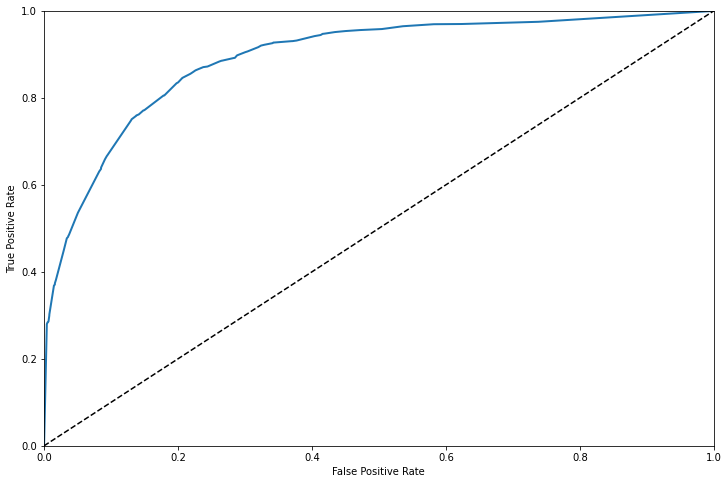

<Figure size 1440x1440 with 0 Axes>

0.892011881874959


In [171]:
decision_tree = gcv_tree.best_estimator_
gcv_tree.best_estimator_

plot_roc_curve(y_test, decision_tree.predict_proba(X_test)[:, 1])

We can see slightly tuned Decision Tree gives an accuracy of `89.2%`. Let us explore other models

In [175]:
print(f'F1-score for Decision Tree: {f1_score(y_test,decision_tree.predict(X_test))}.')

F1-score for Decision Tree: 0.6718788174932812.


/home/bbatayev/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Random Forest

In [160]:
forest_parameters = {'n_estimators': range(1, 200),
                    'criterion': ('gini', 'entropy'),
                    'max_depth': range(0, 50),
                    'min_samples_split': range(2, 15),
                    'bootstrap': [True, False]}
random_forest = RandomForestClassifier()
gcv_forest = RandomizedSearchCV(random_forest, forest_parameters, random_state=42)
gcv_forest.fit(X_train, y_train)

/home/bbatayev/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/bbatayev/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/bbatayev/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 681, 

RandomizedSearchCV(estimator=RandomForestClassifier(),
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ('gini', 'entropy'),
                                        'max_depth': range(0, 50),
                                        'min_samples_split': range(2, 15),
                                        'n_estimators': range(1, 200)},
                   random_state=42)

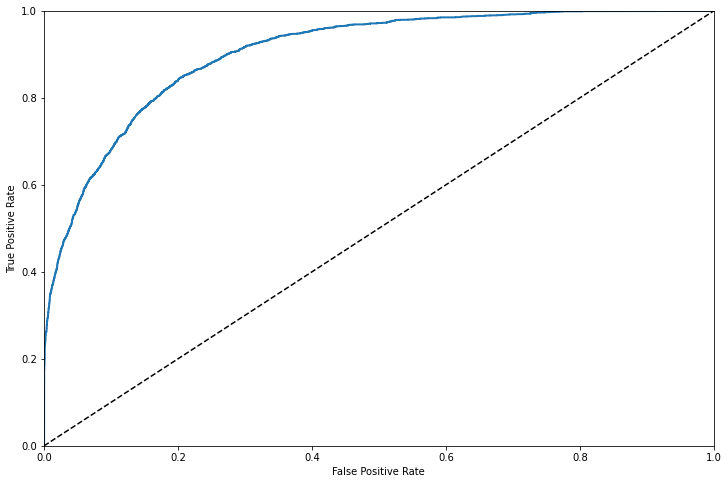

<Figure size 1440x1440 with 0 Axes>

0.9044537291420361


In [163]:
random_forest = gcv_forest.best_estimator_
gcv_forest.best_estimator_
plot_roc_curve(y_test, random_forest.predict_proba(X_test)[:, 1])

Random Forest demonstrates slightly better results of around `90.5%`

In [178]:
print(f'F1-score for Random Forest: {f1_score(y_test, random_forest.predict(X_test))}.')

/home/bbatayev/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


F1-score for Random Forest: 0.6734538050394502.


## LightGBM
Firstly, We will use standard LGBM Classifier and see the results of `ROC-AUC curve` and `F-1 Score`

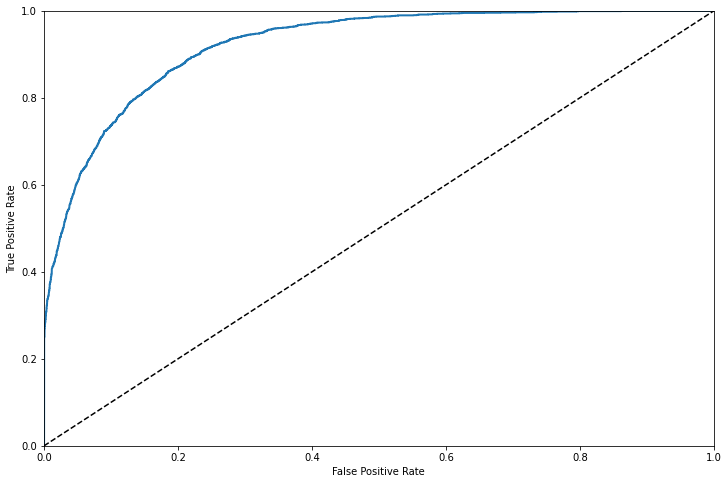

<Figure size 1440x1440 with 0 Axes>

0.9221071328614141


In [180]:
lgb_model = LGBMClassifier()
lgb_model.fit(X_train, y_train)
plot_roc_curve(y_test, lgb_model.predict_proba(X_test)[:, 1])

In [181]:
print(f'F1-score for LightGBM (untuned): {f1_score(y_test, lgb_model.predict(X_test))}.')

F1-score for LightGBM (untuned): 0.7019667170953102.


/home/bbatayev/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### LightGBM Tuned
Now we will slightly tune the model with Randomized Search CV 

In [127]:
params_lgb = {
        'learning_rate' : [0.001, 0.01, 0.1],
        'n_estimators' : [500, 1000, 2000],
        'min_child_weight': [1, 5, 10],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [4, 5, 6]
        }

lgb_model = LGBMClassifier()
search_lgb = RandomizedSearchCV(lgb_model, params_lgb, random_state=42)
search_lgb = search_lgb.fit(X_train, y_train)
search_lgb

/home/bbatayev/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


RandomizedSearchCV(estimator=LGBMClassifier(),
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.001, 0.01, 0.1],
                                        'max_depth': [4, 5, 6],
                                        'min_child_weight': [1, 5, 10],
                                        'n_estimators': [500, 1000, 2000],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42)

/home/bbatayev/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


lgb best params:
 {'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 5, 'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.6}


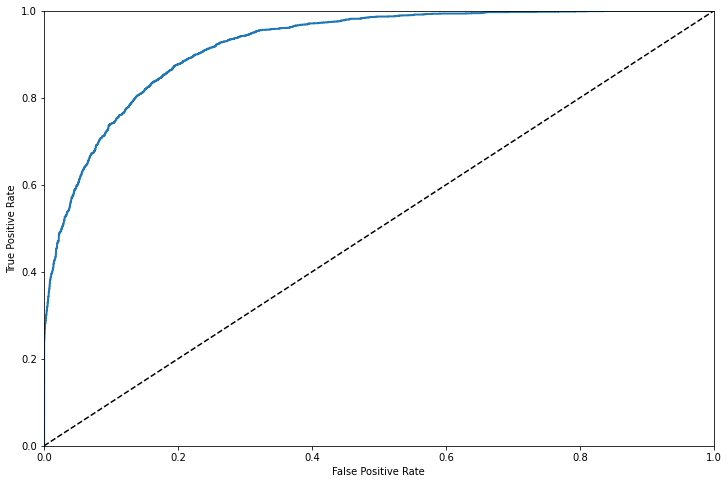

<Figure size 1440x1440 with 0 Axes>

0.9225513813190758


In [164]:
print('lgb best params:\n', search_lgb.best_params_)
tuned_lgb = LGBMClassifier(learning_rate=0.01, max_depth=6, n_estimators=1000, subsample=0.8, min_child_weight=5, colsample_bytree=0.6)
tuned_lgb.fit(X_train, y_train)
plot_roc_curve(y_test, tuned_lgb.predict_proba(X_test)[:, 1])

In [182]:
print(f'F1-score for LightGBM (tuned): {f1_score(y_test, tuned_lgb.predict(X_test))}.')

/home/bbatayev/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


F1-score for LightGBM (tuned): 0.698869475847893.


The AUC-score is slightly higher for the tuned model (`92.55%`), but F1-score is lower (only 0.7)

## XGBoost (tuned)
Now lets tune the XGBoost model

In [183]:
# A parameter grid for XGBoost
params = {
        'learning_rate' : [0.0001, 0.001, 0.01, 0.1],
        'n_estimators' : [200, 500, 1000, 2000],
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 6]
        }

/home/bbatayev/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [112]:
xgb_model = xgb.XGBClassifier()
clf = RandomizedSearchCV(xgb_model, params, random_state=0)
search = clf.fit(X_train, y_train)
search.best_params_

/home/bbatayev/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:11:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bbatayev/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:11:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bbatayev/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:11:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bbatayev/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:12:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bbatayev/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:12:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bbatayev/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:12:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bbatayev/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:12:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bbatayev/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:12:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bbatayev/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:12:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bbatayev/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:12:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bbatayev/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:12:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bbatayev/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:13:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bbatayev/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:15:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bbatayev/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:15:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bbatayev/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:16:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bbatayev/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:17:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bbatayev/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:17:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bbatayev/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:18:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bbatayev/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:18:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bbatayev/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:19:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bbatayev/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:19:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bbatayev/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:19:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bbatayev/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:19:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bbatayev/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:20:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bbatayev/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:20:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bbatayev/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:20:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bbatayev/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:20:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bbatayev/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:21:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bbatayev/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:21:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bbatayev/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:22:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bbatayev/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:22:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bbatayev/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:22:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bbatayev/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:22:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bbatayev/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:22:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bbatayev/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:23:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bbatayev/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:23:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bbatayev/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:23:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bbatayev/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:23:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bbatayev/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:23:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bbatayev/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:23:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bbatayev/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:23:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bbatayev/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:24:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bbatayev/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:24:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bbatayev/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:25:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bbatayev/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:25:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bbatayev/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:26:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bbatayev/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:26:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bbatayev/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:27:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bbatayev/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:27:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bbatayev/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:27:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bbatayev/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:27:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'subsample': 0.8,
 'n_estimators': 1000,
 'min_child_weight': 1,
 'max_depth': 6,
 'learning_rate': 0.01,
 'gamma': 2,
 'colsample_bytree': 1.0}

XGBoost Best Parameters:
 {'subsample': 0.8, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 2, 'colsample_bytree': 1.0}
[15:14:57] WARNING: ../src/learner.cc:573: 
Parameters: { "error_score", "estimator", "estimator__importance_type", "estimator__missing", "estimator__n_estimators", "estimator__objective", "estimator__use_label_encoder", "n_iter", "param_distributions", "pre_dispatch", "refit", "return_train_score", "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:14:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/bbatayev/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


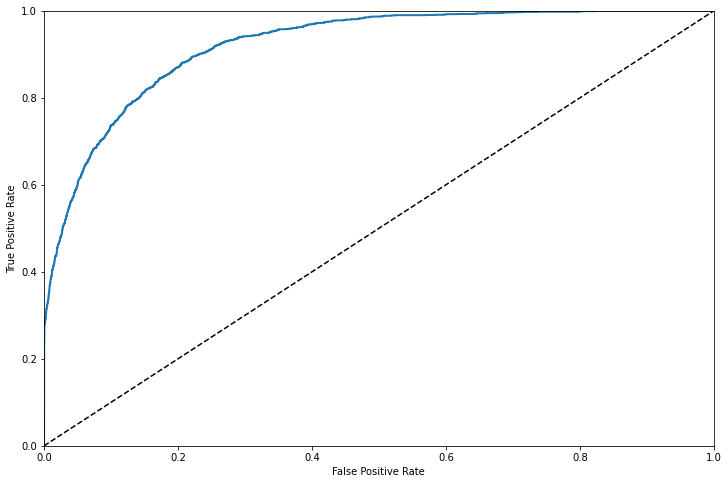

<Figure size 1440x1440 with 0 Axes>

0.9210498617165199


In [184]:
print('XGBoost Best Parameters:\n', search.best_params_)
tuned_xgb = xgb.XGBClassifier(**search.get_params())
tuned_xgb.fit(X_train, y_train)
plot_roc_curve(y_test, tuned_xgb.predict_proba(X_test)[:, 1])

In [185]:
print(f'F1-score for XGBoost (tuned): {f1_score(y_test, tuned_xgb.predict(X_test))}.')

F1-score for XGBoost (tuned): 0.7060000000000001.


/home/bbatayev/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Cross Validation
Let us see how the models will perform on cross-validation

In [211]:
def validate_model(model, X, y):
    '''Validate model'''
    from sklearn.model_selection import cross_val_score
    from sklearn.model_selection import RepeatedKFold
    
    cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)
    n_scores = cross_val_score(
        model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
    print('AUC: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

/home/bbatayev/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [224]:
print('Decision Tree validation:', validate_model(decision_tree, X_train, y_train))


AUC: 0.892 (0.007)
Decision Tree validation: None


In [225]:
print('Random Forest validation:',validate_model(random_forest, X_train, y_train))


AUC: 0.908 (0.005)
Random Forest validation: None


In [226]:
print('LGB model (untuned):,',validate_model(lgb_model, X_train, y_train))


AUC: 0.927 (0.005)
LGB model (untuned):, None


In [227]:
print('LGB model (tuned):,',validate_model(tuned_lgb, X_train, y_train))


AUC: 0.928 (0.005)
LGB model (tuned):, None


In [ ]:
print('XGB model (tuned):', validate_model(tuned_xgb, X_train, y_train)) # Timelimit exceeded

Since validation of `XGB model` took **too much time** (>20 mins), the best model for this dataset is `LGB with tuned hyperparameters`

## Catboost
Finally, I will take a look over `catboost` algorithm. Here I will build a pipeline with encoding, scaling and other preprocessing steps on the `train_df` before feature engineering steps were taken. Then, I will use sklearn `Pipeline` function with OneHotEncoder instead of LabelEncoder

In [230]:
x = train_df.drop(['target'], axis=1)
y = train_df['target']

X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size=0.3, random_state=42)

X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid,
                                                    test_size=0.3,
                                                    stratify=y_valid,
                                                    random_state=4)

In [231]:
# Preprocessing for numerical columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
])

# Preprocessing for categorical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Transforming  numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

/home/bbatayev/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [232]:
catboost = CatBoostClassifier(iterations=3000,
                           learning_rate=1e-2,
                           loss_function='Logloss',
                           eval_metric='F1',
                           use_best_model=True,
                           random_state=4)

In [233]:
# Bundle preprocessing and modeling code in a pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', catboost)
])

pipeline['preprocessor'].fit(X_train)

# Preprocessing of training data, fit model
pipeline.fit(X_train, y_train,
             model__eval_set=(preprocessor.transform(X_valid), y_valid))

# Preprocess the holdout test data and get predictions
catboost_pred = pipeline.predict(X_test)

# Evaluate the model
score = f1_score(y_test, y_pred)
print('F1:', score)

0:	learn: 0.6113825	test: 0.6121021	best: 0.6121021 (0)	total: 20ms	remaining: 59.9s
1:	learn: 0.6328981	test: 0.6293463	best: 0.6293463 (1)	total: 34.7ms	remaining: 52s
2:	learn: 0.6324086	test: 0.6287300	best: 0.6293463 (1)	total: 48ms	remaining: 48s
3:	learn: 0.6243397	test: 0.6235212	best: 0.6293463 (1)	total: 61.5ms	remaining: 46.1s
4:	learn: 0.6278996	test: 0.6240391	best: 0.6293463 (1)	total: 74.9ms	remaining: 44.8s
5:	learn: 0.6289843	test: 0.6209564	best: 0.6293463 (1)	total: 88.4ms	remaining: 44.1s
6:	learn: 0.6274718	test: 0.6199859	best: 0.6293463 (1)	total: 101ms	remaining: 43.3s
7:	learn: 0.6279341	test: 0.6207381	best: 0.6293463 (1)	total: 115ms	remaining: 42.9s
8:	learn: 0.6280429	test: 0.6209564	best: 0.6293463 (1)	total: 128ms	remaining: 42.4s
9:	learn: 0.6291229	test: 0.6212228	best: 0.6293463 (1)	total: 140ms	remaining: 42s
10:	learn: 0.6301775	test: 0.6215363	best: 0.6293463 (1)	total: 154ms	remaining: 41.9s
11:	learn: 0.6337197	test: 0.6266154	best: 0.6293463 (1)	

105:	learn: 0.6384805	test: 0.6371681	best: 0.6381927 (93)	total: 1.68s	remaining: 45.7s
106:	learn: 0.6386266	test: 0.6373938	best: 0.6381927 (93)	total: 1.69s	remaining: 45.7s
107:	learn: 0.6389098	test: 0.6381020	best: 0.6381927 (93)	total: 1.71s	remaining: 45.7s
108:	learn: 0.6391332	test: 0.6381020	best: 0.6381927 (93)	total: 1.73s	remaining: 45.8s
109:	learn: 0.6395449	test: 0.6383280	best: 0.6383280 (109)	total: 1.74s	remaining: 45.7s
110:	learn: 0.6405411	test: 0.6373314	best: 0.6383280 (109)	total: 1.76s	remaining: 45.7s
111:	learn: 0.6409706	test: 0.6378148	best: 0.6383280 (109)	total: 1.77s	remaining: 45.8s
112:	learn: 0.6405931	test: 0.6375577	best: 0.6383280 (109)	total: 1.79s	remaining: 45.8s
113:	learn: 0.6406703	test: 0.6373314	best: 0.6383280 (109)	total: 1.81s	remaining: 45.7s
114:	learn: 0.6409706	test: 0.6373314	best: 0.6383280 (109)	total: 1.82s	remaining: 45.7s
115:	learn: 0.6410311	test: 0.6387509	best: 0.6387509 (115)	total: 1.84s	remaining: 45.7s
116:	learn: 0.

197:	learn: 0.6491096	test: 0.6503024	best: 0.6514936 (191)	total: 3.12s	remaining: 44.2s
198:	learn: 0.6492553	test: 0.6500888	best: 0.6514936 (191)	total: 3.14s	remaining: 44.2s
199:	learn: 0.6495413	test: 0.6500888	best: 0.6514936 (191)	total: 3.15s	remaining: 44.1s
200:	learn: 0.6498327	test: 0.6503198	best: 0.6514936 (191)	total: 3.17s	remaining: 44.1s
201:	learn: 0.6494823	test: 0.6503198	best: 0.6514936 (191)	total: 3.19s	remaining: 44.1s
202:	learn: 0.6495524	test: 0.6500888	best: 0.6514936 (191)	total: 3.2s	remaining: 44.1s
203:	learn: 0.6496980	test: 0.6503198	best: 0.6514936 (191)	total: 3.22s	remaining: 44.1s
204:	learn: 0.6501241	test: 0.6510306	best: 0.6514936 (191)	total: 3.24s	remaining: 44.1s
205:	learn: 0.6504854	test: 0.6510306	best: 0.6514936 (191)	total: 3.25s	remaining: 44.1s
206:	learn: 0.6503398	test: 0.6510306	best: 0.6514936 (191)	total: 3.27s	remaining: 44.1s
207:	learn: 0.6502644	test: 0.6512620	best: 0.6514936 (191)	total: 3.29s	remaining: 44.1s
208:	learn:

291:	learn: 0.6594560	test: 0.6598230	best: 0.6600567 (290)	total: 5.34s	remaining: 49.5s
292:	learn: 0.6598159	test: 0.6591070	best: 0.6600567 (290)	total: 5.35s	remaining: 49.5s
293:	learn: 0.6596018	test: 0.6595820	best: 0.6600567 (290)	total: 5.37s	remaining: 49.5s
294:	learn: 0.6593877	test: 0.6591070	best: 0.6600567 (290)	total: 5.39s	remaining: 49.4s
295:	learn: 0.6596747	test: 0.6591070	best: 0.6600567 (290)	total: 5.41s	remaining: 49.4s
296:	learn: 0.6598887	test: 0.6591070	best: 0.6600567 (290)	total: 5.42s	remaining: 49.3s
297:	learn: 0.6599615	test: 0.6593407	best: 0.6600567 (290)	total: 5.44s	remaining: 49.3s
298:	learn: 0.6598203	test: 0.6593407	best: 0.6600567 (290)	total: 5.45s	remaining: 49.3s
299:	learn: 0.6598930	test: 0.6593407	best: 0.6600567 (290)	total: 5.47s	remaining: 49.3s
300:	learn: 0.6601776	test: 0.6598157	best: 0.6600567 (290)	total: 5.49s	remaining: 49.3s
301:	learn: 0.6603209	test: 0.6595820	best: 0.6600567 (290)	total: 5.52s	remaining: 49.3s
302:	learn

384:	learn: 0.6698514	test: 0.6657284	best: 0.6659627 (382)	total: 7.2s	remaining: 48.9s
385:	learn: 0.6699926	test: 0.6657284	best: 0.6659627 (382)	total: 7.22s	remaining: 48.9s
386:	learn: 0.6700637	test: 0.6657284	best: 0.6659627 (382)	total: 7.23s	remaining: 48.8s
387:	learn: 0.6701348	test: 0.6657284	best: 0.6659627 (382)	total: 7.25s	remaining: 48.8s
388:	learn: 0.6704871	test: 0.6659627	best: 0.6659627 (382)	total: 7.27s	remaining: 48.8s
389:	learn: 0.6704172	test: 0.6659627	best: 0.6659627 (382)	total: 7.28s	remaining: 48.7s
390:	learn: 0.6705583	test: 0.6657284	best: 0.6659627 (382)	total: 7.3s	remaining: 48.7s
391:	learn: 0.6706294	test: 0.6657284	best: 0.6659627 (382)	total: 7.32s	remaining: 48.7s
392:	learn: 0.6708404	test: 0.6657284	best: 0.6659627 (382)	total: 7.34s	remaining: 48.7s
393:	learn: 0.6708404	test: 0.6659627	best: 0.6659627 (382)	total: 7.37s	remaining: 48.7s
394:	learn: 0.6708404	test: 0.6659627	best: 0.6659627 (382)	total: 7.39s	remaining: 48.7s
395:	learn: 

476:	learn: 0.6806723	test: 0.6682978	best: 0.6696927 (460)	total: 8.81s	remaining: 46.6s
477:	learn: 0.6805337	test: 0.6682978	best: 0.6696927 (460)	total: 8.83s	remaining: 46.6s
478:	learn: 0.6800420	test: 0.6682978	best: 0.6696927 (460)	total: 8.85s	remaining: 46.6s
479:	learn: 0.6803864	test: 0.6682978	best: 0.6696927 (460)	total: 8.87s	remaining: 46.5s
480:	learn: 0.6804578	test: 0.6685315	best: 0.6696927 (460)	total: 8.88s	remaining: 46.5s
481:	learn: 0.6804578	test: 0.6685315	best: 0.6696927 (460)	total: 8.9s	remaining: 46.5s
482:	learn: 0.6804578	test: 0.6687653	best: 0.6696927 (460)	total: 8.91s	remaining: 46.4s
483:	learn: 0.6805964	test: 0.6692308	best: 0.6696927 (460)	total: 8.93s	remaining: 46.4s
484:	learn: 0.6806679	test: 0.6687653	best: 0.6696927 (460)	total: 8.94s	remaining: 46.4s
485:	learn: 0.6808779	test: 0.6692335	best: 0.6696927 (460)	total: 8.96s	remaining: 46.3s
486:	learn: 0.6811549	test: 0.6692335	best: 0.6696927 (460)	total: 8.98s	remaining: 46.3s
487:	learn:

576:	learn: 0.6864424	test: 0.6733843	best: 0.6738526 (563)	total: 10.4s	remaining: 43.8s
577:	learn: 0.6864424	test: 0.6733843	best: 0.6738526 (563)	total: 10.4s	remaining: 43.7s
578:	learn: 0.6867885	test: 0.6731504	best: 0.6738526 (563)	total: 10.5s	remaining: 43.7s
579:	learn: 0.6868539	test: 0.6733773	best: 0.6738526 (563)	total: 10.5s	remaining: 43.7s
580:	learn: 0.6869847	test: 0.6738376	best: 0.6738526 (563)	total: 10.5s	remaining: 43.7s
581:	learn: 0.6869193	test: 0.6733773	best: 0.6738526 (563)	total: 10.5s	remaining: 43.6s
582:	learn: 0.6867759	test: 0.6736111	best: 0.6738526 (563)	total: 10.5s	remaining: 43.6s
583:	learn: 0.6870564	test: 0.6736111	best: 0.6738526 (563)	total: 10.5s	remaining: 43.6s
584:	learn: 0.6871217	test: 0.6736111	best: 0.6738526 (563)	total: 10.6s	remaining: 43.6s
585:	learn: 0.6872651	test: 0.6736111	best: 0.6738526 (563)	total: 10.6s	remaining: 43.5s
586:	learn: 0.6873957	test: 0.6736111	best: 0.6738526 (563)	total: 10.6s	remaining: 43.5s
587:	learn

669:	learn: 0.6942833	test: 0.6781293	best: 0.6781293 (669)	total: 11.8s	remaining: 41.2s
670:	learn: 0.6942833	test: 0.6783505	best: 0.6783505 (670)	total: 11.9s	remaining: 41.2s
671:	learn: 0.6944186	test: 0.6783626	best: 0.6783626 (671)	total: 11.9s	remaining: 41.1s
672:	learn: 0.6945537	test: 0.6781293	best: 0.6783626 (671)	total: 11.9s	remaining: 41.1s
673:	learn: 0.6946889	test: 0.6781293	best: 0.6783626 (671)	total: 11.9s	remaining: 41.1s
674:	learn: 0.6946170	test: 0.6774415	best: 0.6783626 (671)	total: 11.9s	remaining: 41.1s
675:	learn: 0.6946170	test: 0.6774415	best: 0.6783626 (671)	total: 11.9s	remaining: 41s
676:	learn: 0.6946170	test: 0.6774415	best: 0.6783626 (671)	total: 11.9s	remaining: 41s
677:	learn: 0.6946170	test: 0.6774415	best: 0.6783626 (671)	total: 12s	remaining: 41s
678:	learn: 0.6946889	test: 0.6774415	best: 0.6783626 (671)	total: 12s	remaining: 40.9s
679:	learn: 0.6946802	test: 0.6774415	best: 0.6783626 (671)	total: 12s	remaining: 40.9s
680:	learn: 0.6948784	

771:	learn: 0.7011542	test: 0.6796581	best: 0.6801232 (768)	total: 13.7s	remaining: 39.4s
772:	learn: 0.7013710	test: 0.6796581	best: 0.6801232 (768)	total: 13.7s	remaining: 39.4s
773:	learn: 0.7012987	test: 0.6796581	best: 0.6801232 (768)	total: 13.7s	remaining: 39.4s
774:	learn: 0.7012987	test: 0.6796581	best: 0.6801232 (768)	total: 13.7s	remaining: 39.4s
775:	learn: 0.7013603	test: 0.6796581	best: 0.6801232 (768)	total: 13.7s	remaining: 39.3s
776:	learn: 0.7013603	test: 0.6794258	best: 0.6801232 (768)	total: 13.7s	remaining: 39.3s
777:	learn: 0.7013603	test: 0.6791937	best: 0.6801232 (768)	total: 13.8s	remaining: 39.3s
778:	learn: 0.7014941	test: 0.6791937	best: 0.6801232 (768)	total: 13.8s	remaining: 39.3s
779:	learn: 0.7016279	test: 0.6794258	best: 0.6801232 (768)	total: 13.8s	remaining: 39.3s
780:	learn: 0.7017002	test: 0.6794258	best: 0.6801232 (768)	total: 13.8s	remaining: 39.2s
781:	learn: 0.7017002	test: 0.6791937	best: 0.6801232 (768)	total: 13.8s	remaining: 39.2s
782:	learn

866:	learn: 0.7072571	test: 0.6800545	best: 0.6814612 (802)	total: 15.1s	remaining: 37s
867:	learn: 0.7075095	test: 0.6800545	best: 0.6814612 (802)	total: 15.1s	remaining: 37s
868:	learn: 0.7077144	test: 0.6800545	best: 0.6814612 (802)	total: 15.1s	remaining: 37s
869:	learn: 0.7077144	test: 0.6805036	best: 0.6814612 (802)	total: 15.1s	remaining: 37s
870:	learn: 0.7079193	test: 0.6809524	best: 0.6814612 (802)	total: 15.1s	remaining: 37s
871:	learn: 0.7076419	test: 0.6809524	best: 0.6814612 (802)	total: 15.1s	remaining: 36.9s
872:	learn: 0.7077742	test: 0.6807208	best: 0.6814612 (802)	total: 15.1s	remaining: 36.9s
873:	learn: 0.7077018	test: 0.6807208	best: 0.6814612 (802)	total: 15.2s	remaining: 36.9s
874:	learn: 0.7078468	test: 0.6802721	best: 0.6814612 (802)	total: 15.2s	remaining: 36.9s
875:	learn: 0.7078468	test: 0.6802721	best: 0.6814612 (802)	total: 15.2s	remaining: 36.8s
876:	learn: 0.7080516	test: 0.6798231	best: 0.6814612 (802)	total: 15.2s	remaining: 36.8s
877:	learn: 0.708184

963:	learn: 0.7146792	test: 0.6829268	best: 0.6831750 (916)	total: 16.5s	remaining: 34.8s
964:	learn: 0.7147374	test: 0.6831583	best: 0.6831750 (916)	total: 16.5s	remaining: 34.8s
965:	learn: 0.7148684	test: 0.6829268	best: 0.6831750 (916)	total: 16.5s	remaining: 34.7s
966:	learn: 0.7149414	test: 0.6829268	best: 0.6831750 (916)	total: 16.5s	remaining: 34.7s
967:	learn: 0.7152764	test: 0.6829268	best: 0.6831750 (916)	total: 16.5s	remaining: 34.7s
968:	learn: 0.7153344	test: 0.6829268	best: 0.6831750 (916)	total: 16.5s	remaining: 34.7s
969:	learn: 0.7152615	test: 0.6829268	best: 0.6831750 (916)	total: 16.6s	remaining: 34.6s
970:	learn: 0.7152034	test: 0.6826956	best: 0.6831750 (916)	total: 16.6s	remaining: 34.6s
971:	learn: 0.7152034	test: 0.6826956	best: 0.6831750 (916)	total: 16.6s	remaining: 34.6s
972:	learn: 0.7152615	test: 0.6826956	best: 0.6831750 (916)	total: 16.6s	remaining: 34.6s
973:	learn: 0.7153195	test: 0.6831415	best: 0.6831750 (916)	total: 16.6s	remaining: 34.5s
974:	learn

1067:	learn: 0.7199269	test: 0.6857914	best: 0.6858108 (1059)	total: 17.9s	remaining: 32.4s
1068:	learn: 0.7200731	test: 0.6857914	best: 0.6858108 (1059)	total: 17.9s	remaining: 32.4s
1069:	learn: 0.7200731	test: 0.6857914	best: 0.6858108 (1059)	total: 17.9s	remaining: 32.4s
1070:	learn: 0.7197400	test: 0.6857914	best: 0.6858108 (1059)	total: 17.9s	remaining: 32.3s
1071:	learn: 0.7197400	test: 0.6857914	best: 0.6858108 (1059)	total: 18s	remaining: 32.3s
1072:	learn: 0.7196831	test: 0.6857914	best: 0.6858108 (1059)	total: 18s	remaining: 32.3s
1073:	learn: 0.7198700	test: 0.6862348	best: 0.6862348 (1073)	total: 18s	remaining: 32.3s
1074:	learn: 0.7199269	test: 0.6866779	best: 0.6866779 (1074)	total: 18s	remaining: 32.2s
1075:	learn: 0.7197970	test: 0.6871207	best: 0.6871207 (1075)	total: 18s	remaining: 32.2s
1076:	learn: 0.7200568	test: 0.6871207	best: 0.6871207 (1075)	total: 18s	remaining: 32.2s
1077:	learn: 0.7199838	test: 0.6871207	best: 0.6871207 (1075)	total: 18s	remaining: 32.2s
10

1161:	learn: 0.7258211	test: 0.6877524	best: 0.6886348 (1157)	total: 19.6s	remaining: 31s
1162:	learn: 0.7258391	test: 0.6879623	best: 0.6886348 (1157)	total: 19.6s	remaining: 31s
1163:	learn: 0.7258391	test: 0.6879623	best: 0.6886348 (1157)	total: 19.7s	remaining: 31s
1164:	learn: 0.7255814	test: 0.6884253	best: 0.6886348 (1157)	total: 19.7s	remaining: 31s
1165:	learn: 0.7255814	test: 0.6884253	best: 0.6886348 (1157)	total: 19.7s	remaining: 31s
1166:	learn: 0.7255814	test: 0.6886570	best: 0.6886570 (1166)	total: 19.7s	remaining: 31s
1167:	learn: 0.7253058	test: 0.6884253	best: 0.6886570 (1166)	total: 19.7s	remaining: 30.9s
1168:	learn: 0.7253792	test: 0.6884253	best: 0.6886570 (1166)	total: 19.7s	remaining: 30.9s
1169:	learn: 0.7255080	test: 0.6884253	best: 0.6886570 (1166)	total: 19.8s	remaining: 30.9s
1170:	learn: 0.7256369	test: 0.6884253	best: 0.6886570 (1166)	total: 19.8s	remaining: 30.9s
1171:	learn: 0.7258945	test: 0.6881937	best: 0.6886570 (1166)	total: 19.8s	remaining: 30.9s


1257:	learn: 0.7294023	test: 0.6893302	best: 0.6895392 (1195)	total: 21.5s	remaining: 29.8s
1258:	learn: 0.7294569	test: 0.6890983	best: 0.6895392 (1195)	total: 21.5s	remaining: 29.8s
1259:	learn: 0.7298416	test: 0.6888665	best: 0.6895392 (1195)	total: 21.6s	remaining: 29.8s
1260:	learn: 0.7297134	test: 0.6888665	best: 0.6895392 (1195)	total: 21.6s	remaining: 29.8s
1261:	learn: 0.7298416	test: 0.6893073	best: 0.6895392 (1195)	total: 21.6s	remaining: 29.7s
1262:	learn: 0.7299697	test: 0.6890983	best: 0.6895392 (1195)	total: 21.6s	remaining: 29.7s
1263:	learn: 0.7297679	test: 0.6893073	best: 0.6895392 (1195)	total: 21.6s	remaining: 29.7s
1264:	learn: 0.7297679	test: 0.6890756	best: 0.6895392 (1195)	total: 21.6s	remaining: 29.7s
1265:	learn: 0.7296397	test: 0.6893073	best: 0.6895392 (1195)	total: 21.7s	remaining: 29.7s
1266:	learn: 0.7296397	test: 0.6890756	best: 0.6895392 (1195)	total: 21.7s	remaining: 29.6s
1267:	learn: 0.7296943	test: 0.6886348	best: 0.6895392 (1195)	total: 21.7s	remai

1354:	learn: 0.7337028	test: 0.6897246	best: 0.6910678 (1285)	total: 23.2s	remaining: 28.1s
1355:	learn: 0.7337028	test: 0.6897246	best: 0.6910678 (1285)	total: 23.2s	remaining: 28.1s
1356:	learn: 0.7338303	test: 0.6894931	best: 0.6910678 (1285)	total: 23.2s	remaining: 28.1s
1357:	learn: 0.7338303	test: 0.6894931	best: 0.6910678 (1285)	total: 23.2s	remaining: 28.1s
1358:	learn: 0.7338303	test: 0.6890531	best: 0.6910678 (1285)	total: 23.2s	remaining: 28.1s
1359:	learn: 0.7338840	test: 0.6890531	best: 0.6910678 (1285)	total: 23.3s	remaining: 28s
1360:	learn: 0.7338101	test: 0.6890531	best: 0.6910678 (1285)	total: 23.3s	remaining: 28s
1361:	learn: 0.7339376	test: 0.6890531	best: 0.6910678 (1285)	total: 23.3s	remaining: 28s
1362:	learn: 0.7339579	test: 0.6890531	best: 0.6910678 (1285)	total: 23.3s	remaining: 28s
1363:	learn: 0.7339579	test: 0.6886127	best: 0.6910678 (1285)	total: 23.3s	remaining: 28s
1364:	learn: 0.7340318	test: 0.6890531	best: 0.6910678 (1285)	total: 23.3s	remaining: 28s


1445:	learn: 0.7360273	test: 0.6908115	best: 0.6912504 (1430)	total: 24.8s	remaining: 26.6s
1446:	learn: 0.7361013	test: 0.6908115	best: 0.6912504 (1430)	total: 24.8s	remaining: 26.6s
1447:	learn: 0.7361013	test: 0.6910433	best: 0.6912504 (1430)	total: 24.8s	remaining: 26.6s
1448:	learn: 0.7359743	test: 0.6912752	best: 0.6912752 (1448)	total: 24.8s	remaining: 26.6s
1449:	learn: 0.7361013	test: 0.6912752	best: 0.6912752 (1448)	total: 24.9s	remaining: 26.6s
1450:	learn: 0.7361013	test: 0.6910433	best: 0.6912752 (1448)	total: 24.9s	remaining: 26.6s
1451:	learn: 0.7361013	test: 0.6908115	best: 0.6912752 (1448)	total: 24.9s	remaining: 26.5s
1452:	learn: 0.7358472	test: 0.6910433	best: 0.6912752 (1448)	total: 24.9s	remaining: 26.5s
1453:	learn: 0.7359743	test: 0.6910433	best: 0.6912752 (1448)	total: 24.9s	remaining: 26.5s
1454:	learn: 0.7359743	test: 0.6910433	best: 0.6912752 (1448)	total: 24.9s	remaining: 26.5s
1455:	learn: 0.7359743	test: 0.6910433	best: 0.6912752 (1448)	total: 25s	remaini

1541:	learn: 0.7383009	test: 0.6927449	best: 0.6931818 (1527)	total: 26.7s	remaining: 25.3s
1542:	learn: 0.7385017	test: 0.6923077	best: 0.6931818 (1527)	total: 26.7s	remaining: 25.2s
1543:	learn: 0.7381957	test: 0.6927449	best: 0.6931818 (1527)	total: 26.8s	remaining: 25.2s
1544:	learn: 0.7383225	test: 0.6927449	best: 0.6931818 (1527)	total: 26.8s	remaining: 25.2s
1545:	learn: 0.7383750	test: 0.6927449	best: 0.6931818 (1527)	total: 26.8s	remaining: 25.2s
1546:	learn: 0.7384276	test: 0.6927449	best: 0.6931818 (1527)	total: 26.8s	remaining: 25.2s
1547:	learn: 0.7384492	test: 0.6927449	best: 0.6931818 (1527)	total: 26.8s	remaining: 25.2s
1548:	learn: 0.7384492	test: 0.6927449	best: 0.6931818 (1527)	total: 26.8s	remaining: 25.1s
1549:	learn: 0.7383966	test: 0.6927449	best: 0.6931818 (1527)	total: 26.9s	remaining: 25.1s
1550:	learn: 0.7383966	test: 0.6927449	best: 0.6931818 (1527)	total: 26.9s	remaining: 25.1s
1551:	learn: 0.7384708	test: 0.6927449	best: 0.6931818 (1527)	total: 26.9s	remai

1640:	learn: 0.7407854	test: 0.6955652	best: 0.6960294 (1623)	total: 28.8s	remaining: 23.8s
1641:	learn: 0.7409342	test: 0.6955652	best: 0.6960294 (1623)	total: 28.8s	remaining: 23.8s
1642:	learn: 0.7407854	test: 0.6960000	best: 0.6960294 (1623)	total: 28.8s	remaining: 23.8s
1643:	learn: 0.7409118	test: 0.6960000	best: 0.6960294 (1623)	total: 28.8s	remaining: 23.8s
1644:	learn: 0.7409118	test: 0.6960000	best: 0.6960294 (1623)	total: 28.8s	remaining: 23.7s
1645:	learn: 0.7409118	test: 0.6960000	best: 0.6960294 (1623)	total: 28.8s	remaining: 23.7s
1646:	learn: 0.7408598	test: 0.6960000	best: 0.6960294 (1623)	total: 28.9s	remaining: 23.7s
1647:	learn: 0.7408598	test: 0.6960000	best: 0.6960294 (1623)	total: 28.9s	remaining: 23.7s
1648:	learn: 0.7408598	test: 0.6960000	best: 0.6960294 (1623)	total: 28.9s	remaining: 23.7s
1649:	learn: 0.7409342	test: 0.6960000	best: 0.6960294 (1623)	total: 28.9s	remaining: 23.7s
1650:	learn: 0.7409342	test: 0.6960000	best: 0.6960294 (1623)	total: 29s	remaini

1734:	learn: 0.7423177	test: 0.6988996	best: 0.6993333 (1728)	total: 30.7s	remaining: 22.3s
1735:	learn: 0.7424440	test: 0.6988996	best: 0.6993333 (1728)	total: 30.7s	remaining: 22.3s
1736:	learn: 0.7421914	test: 0.6984656	best: 0.6993333 (1728)	total: 30.7s	remaining: 22.3s
1737:	learn: 0.7421914	test: 0.6984656	best: 0.6993333 (1728)	total: 30.7s	remaining: 22.3s
1738:	learn: 0.7421914	test: 0.6986667	best: 0.6993333 (1728)	total: 30.7s	remaining: 22.3s
1739:	learn: 0.7424440	test: 0.6986667	best: 0.6993333 (1728)	total: 30.8s	remaining: 22.3s
1740:	learn: 0.7423177	test: 0.6986667	best: 0.6993333 (1728)	total: 30.8s	remaining: 22.3s
1741:	learn: 0.7424669	test: 0.6986667	best: 0.6993333 (1728)	total: 30.8s	remaining: 22.2s
1742:	learn: 0.7425932	test: 0.6982327	best: 0.6993333 (1728)	total: 30.8s	remaining: 22.2s
1743:	learn: 0.7427194	test: 0.6975659	best: 0.6993333 (1728)	total: 30.8s	remaining: 22.2s
1744:	learn: 0.7428457	test: 0.6975659	best: 0.6993333 (1728)	total: 30.8s	remai

1828:	learn: 0.7454089	test: 0.6986347	best: 0.6993333 (1728)	total: 32.5s	remaining: 20.8s
1829:	learn: 0.7451571	test: 0.6988674	best: 0.6993333 (1728)	total: 32.5s	remaining: 20.8s
1830:	learn: 0.7451571	test: 0.6986347	best: 0.6993333 (1728)	total: 32.5s	remaining: 20.8s
1831:	learn: 0.7451571	test: 0.6990679	best: 0.6993333 (1728)	total: 32.6s	remaining: 20.8s
1832:	learn: 0.7451571	test: 0.6990679	best: 0.6993333 (1728)	total: 32.6s	remaining: 20.7s
1833:	learn: 0.7451059	test: 0.6990679	best: 0.6993333 (1728)	total: 32.6s	remaining: 20.7s
1834:	learn: 0.7455586	test: 0.6988674	best: 0.6993333 (1728)	total: 32.6s	remaining: 20.7s
1835:	learn: 0.7454837	test: 0.6984339	best: 0.6993333 (1728)	total: 32.6s	remaining: 20.7s
1836:	learn: 0.7456096	test: 0.6988674	best: 0.6993333 (1728)	total: 32.7s	remaining: 20.7s
1837:	learn: 0.7454837	test: 0.6988674	best: 0.6993333 (1728)	total: 32.7s	remaining: 20.7s
1838:	learn: 0.7456096	test: 0.6980000	best: 0.6993333 (1728)	total: 32.7s	remai

1921:	learn: 0.7481971	test: 0.6980000	best: 0.6993333 (1728)	total: 34.5s	remaining: 19.4s
1922:	learn: 0.7480717	test: 0.6977674	best: 0.6993333 (1728)	total: 34.6s	remaining: 19.4s
1923:	learn: 0.7482721	test: 0.6980000	best: 0.6993333 (1728)	total: 34.6s	remaining: 19.3s
1924:	learn: 0.7480717	test: 0.6980000	best: 0.6993333 (1728)	total: 34.6s	remaining: 19.3s
1925:	learn: 0.7481467	test: 0.6977674	best: 0.6993333 (1728)	total: 34.6s	remaining: 19.3s
1926:	learn: 0.7481467	test: 0.6977674	best: 0.6993333 (1728)	total: 34.7s	remaining: 19.3s
1927:	learn: 0.7483470	test: 0.6977674	best: 0.6993333 (1728)	total: 34.7s	remaining: 19.3s
1928:	learn: 0.7482216	test: 0.6977674	best: 0.6993333 (1728)	total: 34.7s	remaining: 19.3s
1929:	learn: 0.7481467	test: 0.6977674	best: 0.6993333 (1728)	total: 34.7s	remaining: 19.2s
1930:	learn: 0.7480717	test: 0.6973333	best: 0.6993333 (1728)	total: 34.7s	remaining: 19.2s
1931:	learn: 0.7483470	test: 0.6973333	best: 0.6993333 (1728)	total: 34.8s	remai

2020:	learn: 0.7500000	test: 0.6991003	best: 0.6993333 (1728)	total: 36.6s	remaining: 17.7s
2021:	learn: 0.7500000	test: 0.6991003	best: 0.6993333 (1728)	total: 36.6s	remaining: 17.7s
2022:	learn: 0.7498748	test: 0.6991003	best: 0.6993333 (1728)	total: 36.6s	remaining: 17.7s
2023:	learn: 0.7496744	test: 0.6991003	best: 0.6993333 (1728)	total: 36.6s	remaining: 17.7s
2024:	learn: 0.7497997	test: 0.6991003	best: 0.6993333 (1728)	total: 36.7s	remaining: 17.7s
2025:	learn: 0.7497997	test: 0.6995336	best: 0.6995336 (2025)	total: 36.7s	remaining: 17.6s
2026:	learn: 0.7499249	test: 0.6995336	best: 0.6995336 (2025)	total: 36.7s	remaining: 17.6s
2027:	learn: 0.7500000	test: 0.6986667	best: 0.6995336 (2025)	total: 36.7s	remaining: 17.6s
2028:	learn: 0.7502003	test: 0.6986667	best: 0.6995336 (2025)	total: 36.8s	remaining: 17.6s
2029:	learn: 0.7500751	test: 0.6986667	best: 0.6995336 (2025)	total: 36.8s	remaining: 17.6s
2030:	learn: 0.7499249	test: 0.6986667	best: 0.6995336 (2025)	total: 36.8s	remai

2117:	learn: 0.7514011	test: 0.6993007	best: 0.7001664 (2052)	total: 38.4s	remaining: 16s
2118:	learn: 0.7514011	test: 0.6993007	best: 0.7001664 (2052)	total: 38.4s	remaining: 16s
2119:	learn: 0.7514011	test: 0.6993007	best: 0.7001664 (2052)	total: 38.4s	remaining: 16s
2120:	learn: 0.7514011	test: 0.6993007	best: 0.7001664 (2052)	total: 38.4s	remaining: 15.9s
2121:	learn: 0.7514011	test: 0.6993007	best: 0.7001664 (2052)	total: 38.5s	remaining: 15.9s
2122:	learn: 0.7514011	test: 0.6993007	best: 0.7001664 (2052)	total: 38.5s	remaining: 15.9s
2123:	learn: 0.7515261	test: 0.6993007	best: 0.7001664 (2052)	total: 38.5s	remaining: 15.9s
2124:	learn: 0.7515261	test: 0.6993007	best: 0.7001664 (2052)	total: 38.5s	remaining: 15.9s
2125:	learn: 0.7515261	test: 0.6993007	best: 0.7001664 (2052)	total: 38.5s	remaining: 15.8s
2126:	learn: 0.7514509	test: 0.6993007	best: 0.7001664 (2052)	total: 38.6s	remaining: 15.8s
2127:	learn: 0.7513259	test: 0.6993007	best: 0.7001664 (2052)	total: 38.6s	remaining: 

2207:	learn: 0.7543474	test: 0.7007979	best: 0.7010309 (2156)	total: 40.1s	remaining: 14.4s
2208:	learn: 0.7544719	test: 0.7003658	best: 0.7010309 (2156)	total: 40.1s	remaining: 14.4s
2209:	learn: 0.7544719	test: 0.7007979	best: 0.7010309 (2156)	total: 40.1s	remaining: 14.3s
2210:	learn: 0.7543474	test: 0.7003658	best: 0.7010309 (2156)	total: 40.2s	remaining: 14.3s
2211:	learn: 0.7543474	test: 0.7003658	best: 0.7010309 (2156)	total: 40.2s	remaining: 14.3s
2212:	learn: 0.7544719	test: 0.7003658	best: 0.7010309 (2156)	total: 40.2s	remaining: 14.3s
2213:	learn: 0.7545209	test: 0.6999335	best: 0.7010309 (2156)	total: 40.3s	remaining: 14.3s
2214:	learn: 0.7543965	test: 0.6999335	best: 0.7010309 (2156)	total: 40.3s	remaining: 14.3s
2215:	learn: 0.7543965	test: 0.6997007	best: 0.7010309 (2156)	total: 40.3s	remaining: 14.3s
2216:	learn: 0.7545209	test: 0.6997007	best: 0.7010309 (2156)	total: 40.4s	remaining: 14.3s
2217:	learn: 0.7546454	test: 0.6997007	best: 0.7010309 (2156)	total: 40.4s	remai

2300:	learn: 0.7562338	test: 0.6998672	best: 0.7010309 (2156)	total: 42.2s	remaining: 12.8s
2301:	learn: 0.7563092	test: 0.6994354	best: 0.7010309 (2156)	total: 42.2s	remaining: 12.8s
2302:	learn: 0.7564333	test: 0.6994354	best: 0.7010309 (2156)	total: 42.2s	remaining: 12.8s
2303:	learn: 0.7564333	test: 0.6994354	best: 0.7010309 (2156)	total: 42.2s	remaining: 12.8s
2304:	learn: 0.7564333	test: 0.6994354	best: 0.7010309 (2156)	total: 42.2s	remaining: 12.7s
2305:	learn: 0.7563578	test: 0.6998672	best: 0.7010309 (2156)	total: 42.2s	remaining: 12.7s
2306:	learn: 0.7563578	test: 0.6996349	best: 0.7010309 (2156)	total: 42.3s	remaining: 12.7s
2307:	learn: 0.7563578	test: 0.6996349	best: 0.7010309 (2156)	total: 42.3s	remaining: 12.7s
2308:	learn: 0.7563578	test: 0.6998672	best: 0.7010309 (2156)	total: 42.3s	remaining: 12.7s
2309:	learn: 0.7562338	test: 0.6998672	best: 0.7010309 (2156)	total: 42.3s	remaining: 12.6s
2310:	learn: 0.7562338	test: 0.6998672	best: 0.7010309 (2156)	total: 42.3s	remai

2395:	learn: 0.7576030	test: 0.7011266	best: 0.7013590 (2363)	total: 43.8s	remaining: 11s
2396:	learn: 0.7577268	test: 0.7011266	best: 0.7013590 (2363)	total: 43.8s	remaining: 11s
2397:	learn: 0.7577268	test: 0.7011266	best: 0.7013590 (2363)	total: 43.8s	remaining: 11s
2398:	learn: 0.7577268	test: 0.7011266	best: 0.7013590 (2363)	total: 43.8s	remaining: 11s
2399:	learn: 0.7576030	test: 0.7011266	best: 0.7013590 (2363)	total: 43.8s	remaining: 11s
2400:	learn: 0.7578507	test: 0.7011266	best: 0.7013590 (2363)	total: 43.8s	remaining: 10.9s
2401:	learn: 0.7577268	test: 0.7011266	best: 0.7013590 (2363)	total: 43.9s	remaining: 10.9s
2402:	learn: 0.7577268	test: 0.7011266	best: 0.7013590 (2363)	total: 43.9s	remaining: 10.9s
2403:	learn: 0.7578779	test: 0.7006961	best: 0.7013590 (2363)	total: 43.9s	remaining: 10.9s
2404:	learn: 0.7578779	test: 0.7006961	best: 0.7013590 (2363)	total: 43.9s	remaining: 10.9s
2405:	learn: 0.7580018	test: 0.7006961	best: 0.7013590 (2363)	total: 43.9s	remaining: 10.8

2494:	learn: 0.7594659	test: 0.7022193	best: 0.7024520 (2455)	total: 45.6s	remaining: 9.22s
2495:	learn: 0.7593423	test: 0.7022193	best: 0.7024520 (2455)	total: 45.6s	remaining: 9.2s
2496:	learn: 0.7593423	test: 0.7022193	best: 0.7024520 (2455)	total: 45.6s	remaining: 9.19s
2497:	learn: 0.7592943	test: 0.7022193	best: 0.7024520 (2455)	total: 45.6s	remaining: 9.17s
2498:	learn: 0.7594180	test: 0.7022193	best: 0.7024520 (2455)	total: 45.6s	remaining: 9.15s
2499:	learn: 0.7594180	test: 0.7022193	best: 0.7024520 (2455)	total: 45.6s	remaining: 9.13s
2500:	learn: 0.7594180	test: 0.7022193	best: 0.7024520 (2455)	total: 45.7s	remaining: 9.11s
2501:	learn: 0.7592943	test: 0.7022193	best: 0.7024520 (2455)	total: 45.7s	remaining: 9.09s
2502:	learn: 0.7594180	test: 0.7022193	best: 0.7024520 (2455)	total: 45.7s	remaining: 9.07s
2503:	learn: 0.7594937	test: 0.7022193	best: 0.7024520 (2455)	total: 45.7s	remaining: 9.05s
2504:	learn: 0.7594937	test: 0.7022193	best: 0.7024520 (2455)	total: 45.7s	remain

2590:	learn: 0.7610989	test: 0.7017893	best: 0.7024520 (2455)	total: 47.2s	remaining: 7.45s
2591:	learn: 0.7609756	test: 0.7017893	best: 0.7024520 (2455)	total: 47.2s	remaining: 7.43s
2592:	learn: 0.7610989	test: 0.7017893	best: 0.7024520 (2455)	total: 47.2s	remaining: 7.41s
2593:	learn: 0.7612505	test: 0.7017893	best: 0.7024520 (2455)	total: 47.2s	remaining: 7.39s
2594:	learn: 0.7612505	test: 0.7017893	best: 0.7024520 (2455)	total: 47.3s	remaining: 7.37s
2595:	learn: 0.7611272	test: 0.7017893	best: 0.7024520 (2455)	total: 47.3s	remaining: 7.36s
2596:	learn: 0.7612505	test: 0.7017893	best: 0.7024520 (2455)	total: 47.3s	remaining: 7.34s
2597:	learn: 0.7612505	test: 0.7013590	best: 0.7024520 (2455)	total: 47.3s	remaining: 7.32s
2598:	learn: 0.7610989	test: 0.7013590	best: 0.7024520 (2455)	total: 47.3s	remaining: 7.3s
2599:	learn: 0.7610989	test: 0.7015915	best: 0.7024520 (2455)	total: 47.3s	remaining: 7.28s
2600:	learn: 0.7612980	test: 0.7018242	best: 0.7024520 (2455)	total: 47.3s	remain

2689:	learn: 0.7630035	test: 0.7026848	best: 0.7026848 (2641)	total: 48.8s	remaining: 5.63s
2690:	learn: 0.7630035	test: 0.7026848	best: 0.7026848 (2641)	total: 48.8s	remaining: 5.61s
2691:	learn: 0.7630035	test: 0.7026848	best: 0.7026848 (2641)	total: 48.8s	remaining: 5.59s
2692:	learn: 0.7630035	test: 0.7026848	best: 0.7026848 (2641)	total: 48.9s	remaining: 5.57s
2693:	learn: 0.7631265	test: 0.7026848	best: 0.7026848 (2641)	total: 48.9s	remaining: 5.55s
2694:	learn: 0.7631265	test: 0.7026848	best: 0.7026848 (2641)	total: 48.9s	remaining: 5.53s
2695:	learn: 0.7631736	test: 0.7026848	best: 0.7026848 (2641)	total: 48.9s	remaining: 5.51s
2696:	learn: 0.7632495	test: 0.7026848	best: 0.7026848 (2641)	total: 48.9s	remaining: 5.5s
2697:	learn: 0.7631736	test: 0.7026848	best: 0.7026848 (2641)	total: 48.9s	remaining: 5.48s
2698:	learn: 0.7631736	test: 0.7026848	best: 0.7026848 (2641)	total: 49s	remaining: 5.46s
2699:	learn: 0.7633724	test: 0.7026848	best: 0.7026848 (2641)	total: 49s	remaining:

2781:	learn: 0.7647059	test: 0.7024520	best: 0.7033477 (2719)	total: 50.5s	remaining: 3.96s
2782:	learn: 0.7647059	test: 0.7024520	best: 0.7033477 (2719)	total: 50.5s	remaining: 3.94s
2783:	learn: 0.7648286	test: 0.7024520	best: 0.7033477 (2719)	total: 50.5s	remaining: 3.92s
2784:	learn: 0.7648286	test: 0.7024520	best: 0.7033477 (2719)	total: 50.5s	remaining: 3.9s
2785:	learn: 0.7647059	test: 0.7024520	best: 0.7033477 (2719)	total: 50.5s	remaining: 3.88s
2786:	learn: 0.7647059	test: 0.7024520	best: 0.7033477 (2719)	total: 50.6s	remaining: 3.86s
2787:	learn: 0.7647059	test: 0.7024520	best: 0.7033477 (2719)	total: 50.6s	remaining: 3.85s
2788:	learn: 0.7651033	test: 0.7024520	best: 0.7033477 (2719)	total: 50.6s	remaining: 3.83s
2789:	learn: 0.7651794	test: 0.7024520	best: 0.7033477 (2719)	total: 50.6s	remaining: 3.81s
2790:	learn: 0.7651794	test: 0.7024520	best: 0.7033477 (2719)	total: 50.6s	remaining: 3.79s
2791:	learn: 0.7653021	test: 0.7024520	best: 0.7033477 (2719)	total: 50.6s	remain

2871:	learn: 0.7657631	test: 0.7028458	best: 0.7033477 (2719)	total: 52.1s	remaining: 2.32s
2872:	learn: 0.7657631	test: 0.7028458	best: 0.7033477 (2719)	total: 52.1s	remaining: 2.3s
2873:	learn: 0.7658391	test: 0.7028458	best: 0.7033477 (2719)	total: 52.1s	remaining: 2.29s
2874:	learn: 0.7659152	test: 0.7028458	best: 0.7033477 (2719)	total: 52.2s	remaining: 2.27s
2875:	learn: 0.7659152	test: 0.7026133	best: 0.7033477 (2719)	total: 52.2s	remaining: 2.25s
2876:	learn: 0.7659152	test: 0.7028458	best: 0.7033477 (2719)	total: 52.2s	remaining: 2.23s
2877:	learn: 0.7659152	test: 0.7028458	best: 0.7033477 (2719)	total: 52.2s	remaining: 2.21s
2878:	learn: 0.7659152	test: 0.7028458	best: 0.7033477 (2719)	total: 52.2s	remaining: 2.19s
2879:	learn: 0.7659152	test: 0.7024164	best: 0.7033477 (2719)	total: 52.2s	remaining: 2.18s
2880:	learn: 0.7659152	test: 0.7026490	best: 0.7033477 (2719)	total: 52.3s	remaining: 2.16s
2881:	learn: 0.7659152	test: 0.7026490	best: 0.7033477 (2719)	total: 52.3s	remain

2962:	learn: 0.7674465	test: 0.7034346	best: 0.7037037 (2898)	total: 53.7s	remaining: 671ms
2963:	learn: 0.7672021	test: 0.7027741	best: 0.7037037 (2898)	total: 53.8s	remaining: 653ms
2964:	learn: 0.7670798	test: 0.7027741	best: 0.7037037 (2898)	total: 53.8s	remaining: 635ms
2965:	learn: 0.7670798	test: 0.7027741	best: 0.7037037 (2898)	total: 53.8s	remaining: 617ms
2966:	learn: 0.7669576	test: 0.7032024	best: 0.7037037 (2898)	total: 53.8s	remaining: 598ms
2967:	learn: 0.7669576	test: 0.7032024	best: 0.7037037 (2898)	total: 53.8s	remaining: 580ms
2968:	learn: 0.7669576	test: 0.7032024	best: 0.7037037 (2898)	total: 53.8s	remaining: 562ms
2969:	learn: 0.7669576	test: 0.7032024	best: 0.7037037 (2898)	total: 53.9s	remaining: 544ms
2970:	learn: 0.7670798	test: 0.7025421	best: 0.7037037 (2898)	total: 53.9s	remaining: 526ms
2971:	learn: 0.7672021	test: 0.7021136	best: 0.7037037 (2898)	total: 53.9s	remaining: 508ms
2972:	learn: 0.7673243	test: 0.7025421	best: 0.7037037 (2898)	total: 53.9s	remai

In [234]:
print(f'F1-score for Catboost: {f1_score(y_test, catboost_pred)}.')

F1-score for Catboost: 0.726698262243286.


/home/bbatayev/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/bbatayev/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


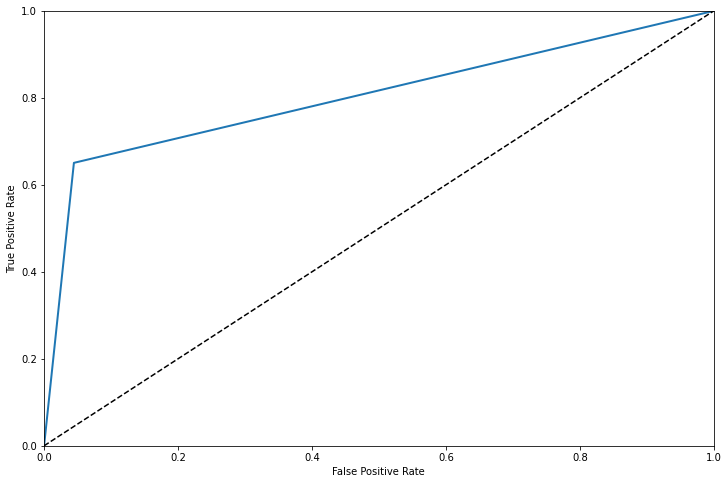

<Figure size 1440x1440 with 0 Axes>

0.8030410183875529


In [235]:
plot_roc_curve(y_test, catboost_pred)

Catboost model shows good F1-score value but ROC-AUC curve is not so great

## Making Predictions  <a name="making_predictions"></a>
Since I have built a pipeline for a Catboost model and used preprocessing tools (with different encoding and normalizing), I will pick two to predict output on test dataset: `Catboost` and `LigthGBM (tuned)`.  

### Saving Catboost Prediction

In [236]:
catboost_prediction = pipeline.predict(test_df)

/home/bbatayev/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [238]:
catboost_pred_df = pd.DataFrame(catboost_prediction, columns=['target'])
catboost_pred_df['target'] = catboost_pred_df['target'].map(inv_target)

In [242]:

output_path = 'output_catboost.txt'


with open(test_data_path, 'r') as fin, open(output_path, 'w') as fout:
    in_lines = fin.readlines()
    out_lines = [in_lines[0]]

    for line, pred in zip(in_lines[1:], catboost_pred_df['target'].values):
        out_lines.append(line.rstrip() + ', ' + pred + '\n')

    fout.writelines(out_lines)

###  Saving LightGBM (tuned) prediction

In [261]:
test_df.head()

,age,work_class,final_weight,education,education_num,marital_status,occupation,relationship,race,sex,cap_gain,cap_loss,hours_per_week,native_country
0,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States
1,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States
2,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States
3,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States
4,18,?,103497.0,Some-college,10.0,Never-married,?,Own-child,White,Female,0.0,0.0,30.0,United-States


In [257]:
new_test_df = test_df.copy()
new_test_df['cap_diff'] = new_test_df['cap_gain'] - new_test_df['cap_loss']
new_test_df = new_test_df.drop(columns=['final_weight', 'cap_gain', 'cap_loss'], axis=1)
new_test_df['age'] = new_test_df['age'].astype(np.uint8)

In [258]:
for col in categorical_columns:
    encode_categorical_features(new_test_df, test_df, col)

In [259]:
lgbm_prediction = tuned_lgb.predict(new_test_df)
lgbm_pred_df = pd.DataFrame(lgbm_prediction, columns=['target'])
lgbm_pred_df['target'] = lgbm_pred_df['target'].map(inv_target)

In [262]:
output_path = 'output_lgbm.txt'


with open(test_data_path, 'r') as fin, open(output_path, 'w') as fout:
    in_lines = fin.readlines()
    out_lines = [in_lines[0]]

    for line, pred in zip(in_lines[1:], lgbm_pred_df['target'].values):
        out_lines.append(line.rstrip() + ', ' + pred + '\n')

    fout.writelines(out_lines)

/home/bbatayev/.local/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


That marks the end of this notebook